### Load Python libraries

In [1]:
import pandas as pd

import numpy as np
from numpy import interp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from scipy.interpolate import interp1d
from scipy.interpolate import splrep, splev
from scipy.stats import linregress

import fiona

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import textwrap as tw

import rasterio as rs
from rasterio.plot import show
import rasterio.mask

import xarray

import itertools 
from itertools import product

import math

encoding = "utf_8"

In [2]:
# Modify display width
# (This is a personal preference)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Definitions

In [3]:
gases = ['CO2','CH4','N2O']
emission_units = {'CO2' : 'Gt','CH4' : 'Mt', 'N2O' : 'Mt'}
gas_units = {'CO2' : 'ppm','CH4' : 'ppb', 'N2O' : 'ppb'}

### Utility Functions

In [4]:
# convert a string to an int if it can be
# otherwise keep it a string

def stoi(s):
    try: 
        si = int(s)
        return si
    except ValueError:
        return s

In [5]:
def colfix (df,n):
    df.columns = [c[0] for c in df.columns[0:n]] + [c[1] for c in df.columns[n:]]

In [6]:
# A dataframe that stores key values as they are generated

constants = pd.DataFrame(columns=['Variable','Value','Units'])
constants = constants.set_index('Variable')

# Introduction
The use of animals as a food-production technology has substantial negative impacts on our climate and environment. The historical reduction in terrestrial biomass as native ecosystems were transformed to support grazing livestock and the cultivation of feed and forage crops accounts for as much as a third of all anthropogenic CO2 emissions to date (Hayek et al., 2021; Strassburg et al., 2020), and is a primary driver of the ongoing global collapse of wildlife populations (Newbold et al., 2015; World Wildlife Fund, 2020). Livestock, especially large ruminants, and their supply chains, also contribute significantly to anthropogenic emissions of the potent greenhouse gases methane and nitrous oxide (Gerber et al., 2013; MacLeod et al., 2018; Steinfeld et al., 2006).

Major cuts in food-linked emissions are likely necessary by 2075 to limit global warming to 1.5°C, even in the context of large-scale reduction in emissions from other sources (Clark et al., 2020). Some reductions can likely be achieved by increasing agricultural efficiency, reducing food waste, limiting excess consumption, increasing yields, and reducing the emission intensity of livestock production (Hristov et al., 2013a, 2013b; Montes et al., 2013), although the magnitude of what such interventions can achieve is currently unknown. However, a recent analysis found that, of these options, a global transition to a plant-rich diet would be, by far, the most impactful (Clark et al., 2020)).

Nutritionally balanced plant-dominated diets (Agnoli et al., 2017; American Dietetic Association and Dietitians of Canada, 2003; Craig et al., 2009; Tilman and Clark, 2014; Willett et al., 2019) are common and diverse. Their global adoption would have an immediate positive impact on greenhouse gas emissions (MacLeod et al., 2020, 2018; Steinfeld et al., 2006), biodiversity (Maron et al., 2018; Strassburg et al., 2020) and human health (Clark et al., 2019; Satija et al., 2017; Springmann et al., 2016; Tilman and Clark, 2014), and could play an important role in climate-change mitigation (Clark et al., 2020; Gerber et al., 2013).

Our goal here was to quantify the full impact that contemporary livestock production has on the climate, taking into account the currently unrealized opportunities of emission reduction and biomass recovery together. This approach differs from other recent studies in that we did not attempt to predict how global food production and consumption might change with growing populations, economic development, advances in agriculture, climate change and other socioeconomic factors. 

Instead, we used publicly available, systematic data on livestock production in 2019 (FAO 2021), livestock-linked emissions (MacLeod et al., 2018), and biomass recovery potential on land currently used to support livestock (Hayek et al., 2021; Strassburg et al., 2020) to predict how the immediate or phased elimination of all or parts of global animal agriculture production would alter 2019 net anthropogenic emissions. We used a simple climate model to project how these changes would impact atmospheric GHG levels and warming for the rest of the century, assuming that all other sources of emissions remain constant at 2019 levels. 

We quantified the combined impact of reduced emissions and biomass recovery by comparing the cumulative reduction in the global warming potential of GHGs in the atmosphere for the remainder of the 21st century of different livestock replacement scenarios to those that would be achieved by constant annual reductions in CO2 emissions. Notably, we find that the gradual replacement, over the next 15 years, of the current livestock-rich global diet with a plant-only diet would have a beneficial warming effect equivalent to a 25-Gt annual reduction in CO2 emissions, roughly half of all current annual emissions from human activity, and around two-thirds of those from the combustion of fossil fuels.


# Data Sources

### FAOSTAT

We obtained data on livestock production and trade from the United Nations Food and Agriculture Organization's FAOSTAT database, downloaded in full from: http://www.fao.org/faostat/en/.

We preprocessed the data to select only data for relevant years and products using so that the files were small enough to redistribute here using scripts in FAO_Filter.ipynb. 

### GLEAM

We use data from the United Nations Food and Agriculture Organization (FAO) Global Livestock Environmental Assessment Model [GLEAM](http://www.fao.org/gleam/resources/en/), version 2.0, to estimate gloabl emissions from animal agriculture. GLEAM is a modelling framework that simulates the interaction of activities and processes involved in livestock production and the environment. It was designed to allow policymakers to study the environmental consequences of changes in different steps of livestock supply chains. But we make use only of its baseline model of emissions broken down by species, product and region. 

### Hayek Biomass Recovery

To model the recovery of biomass on land currently used in livestock production, we used the median estimate of (Hayek et al., 2021), who used satellite imagery of biomass and geographically-resolved agricultural data to estimate that the return of land currently used in livestock production to its native state would sequester, over 30 years, 216 Gt of carbon in plant and non-living biomass.

### FAOSTAT Country Information

We need to use a consistent set of countries and country names. We use the FAOSTAT country list as our reference, and have accumulated a set of alternative names, punctuations and spellings from other datasets that we load here and use throughout.

In [7]:
country_group = pd.read_csv("FAOSTAT/FAOSTAT_Country_Group.csv",encoding = encoding)
fao_countries = list((pd.read_csv("Inputs/fao_countries.csv", encoding = encoding))['Area'].unique())

country_aliases = pd.read_csv("Inputs/country_aliases.csv",encoding = encoding)
country_alias_map = {}

for i,r in country_aliases.iterrows():
    country_alias_map[r['Alias']] = r['FAO Country']

for faoc in fao_countries:
    country_alias_map[faoc] = faoc


## FAOSTAT  Total Emissions Data

In [8]:
datafile = "FAOSTAT/Filtered/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv"
fao_emissions = pd.read_csv(datafile,encoding = encoding)
fao_emissions = fao_emissions[fao_emissions.Area == "World"]
fao_emissions_pt = fao_emissions.pivot_table(index=['Item','Element','Unit'], columns=['Year'],aggfunc={'Value' : sum}).reset_index()
fao_emissions_pt.columns = [c[0] for c in fao_emissions_pt.columns[0:3]] + [c[1] for c in fao_emissions_pt.columns[3:]]
for y in [2018,2019]:
    fao_emissions_pt[y] = fao_emissions_pt[2000] + (y/2017) * (fao_emissions_pt[2017] - fao_emissions_pt[2000])
fao_emissions_pt = fao_emissions_pt.set_index(['Item','Element'])

In [9]:
df = fao_emissions_pt.reset_index()[['Item','Element',2019]]
df = df[df.Element.isin(['CO2 emissions','CH4 emissions','N2O emissions'])]

c = "CO2 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+06
c = "CH4 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03
c = "N2O emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03

fao_emissions_2019 = df.pivot_table(index='Element',columns='Item').fillna(0)
fao_emissions_2019.columns = [c[1] for c in fao_emissions_2019.columns]
fao_emissions_2019['Total without agriculture'] = fao_emissions_2019['Total emissions with agricultural land use'] - fao_emissions_2019['Agriculture and related land use']

In [10]:
for col in ['Agricultural land use', 'Agriculture and related land use',
       'Agriculture total', 'Energy', 
       'Total emissions with agricultural land use',
       'Total emissions without land use', 
       'Total without agriculture']:
    
    for gas in gases:
        constants.loc['Emissions|%s|%s' % (col,gas)] = [fao_emissions_2019.loc['%s emissions' % gas][col], emission_units[gas]]

## FAOSTAT Emissions By Country

In [11]:
datafile = "FAOSTAT/Filtered/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv"
fao_emissions_c = pd.read_csv(datafile,encoding = encoding)
fao_emissions_c = fao_emissions_c[fao_emissions_c.Area.isin(fao_countries)]
fao_emissions_c_pt = fao_emissions_c[fao_emissions_c.Element.isin(['CO2 emissions','CH4 emissions','N2O emissions'])].pivot_table(index=['Area','Item','Element','Unit'], columns=['Year'],aggfunc={'Value' : sum}).reset_index()
fao_emissions_c_pt.columns = [c[0] for c in fao_emissions_c_pt.columns[0:3]] + [c[1] for c in fao_emissions_c_pt.columns[3:]]

# projections scale 2018 and 2019 global emissions data by emissions share in 2017
for i,r in fao_emissions_c_pt.groupby(['Item','Element']):
    fao_emissions_c_pt.loc[r.index,2018] = fao_emissions_pt.loc[i][2018] *  r[2017] / r.sum()[2017]
    fao_emissions_c_pt.loc[r.index,2019] = fao_emissions_pt.loc[i][2019] *  r[2017] / r.sum()[2017]
    
fao_emissions_c_pt = fao_emissions_c_pt.set_index(['Area','Item','Element'])

In [12]:
df = fao_emissions_c_pt.reset_index()[['Area','Item','Element',2019]]
df = df[df.Element.isin(['CO2 emissions','CH4 emissions','N2O emissions'])]
c = "CO2 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+06
c = "CH4 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03
c = "N2O emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03

fao_emissions_c_2019 = df.pivot_table(index=['Area','Element'],columns='Item').fillna(0)
fao_emissions_c_2019.columns = [c[1] for c in fao_emissions_c_2019.columns]
fao_emissions_c_2019['Total without agriculture'] = fao_emissions_c_2019['Total emissions with agricultural land use'] - fao_emissions_c_2019['Agriculture and related land use']

# Updating Estimates of Emissions from Animal Agriculture

We obtained livestock production data for 2019 (the most recent year available) from the “Production_LivestockPrimary” datafile in FAOSTAT (FAO 2021). We extracted from Production_LivestockPrimary the amount (in tonnes), for all countries, of primary domestic production of meat from cattle, buffalo, sheep, goat, pig, chicken and duck, milk from cows, buffalo, sheep and goat, and eggs from poultry.  We computed meat and protein yields from the carcass weight data reported by GLEAM. We scaled the GLEAM emission data reported for entire herds based on carcass weight for meat, and production weight for milk and eggs. As GLEAM does not provide data for ducks, we used values for chicken. The scaling was done using country-specific livestock production data and regional data from GLEAM. 


### Species and Production Emissions Data From Global GLEAM 2.0 

We obtained country, species, herd and product type specific CO2, CH4 and N2O emission data for terrestrial livestock from the public version of GLEAM 2.0 (MacLeod et al. 2018) downloaded from http://www.fao.org/gleam/results/en/. GLEAM contains data for cattle, buffalo, sheep, goats, pigs and chickens, and attributes emissions to meat, milk and eggs. Although GLEAM further breaks down emissions based on herd type and production system, we used aggregate data for all herds and production types in the country. We did not include CO2 emissions linked to land-use change, as this is associated with increases in livestock production which are explicitly not considered by our model. 

Direct link to the public data [available here]( http://www.fao.org/fileadmin/user_upload/gleam/docs/GLEAM_Data_public_release.xlsx).



In [13]:
# This is a lookup table to connect category, product and production process from GLEAM to species/product pairs

commodity_info = pd.DataFrame( data = 
    [
        ['Meat','buffalo_meat','Buffalo','All systems','Whole herd','Buffalo'],
        ['Meat','cattle_meat','Cattle','All systems','Whole herd','Cattle'],
        ['Meat','chicken_meat','Chickens','All systems','Whole herd','Chickens'],
        ['Meat','duck_meat','Chickens','All systems','Whole herd','Ducks'], # no GLEAM data so use Chickens
        ['Meat','goat_meat','Goats', 'All systems','Whole herd','Goats'],
        ['Meat','sheep_meat','Sheep', 'All systems','Whole herd','Sheep'],
        ['Meat','pig_meat','Pigs', 'All systems','Whole herd','Pigs'],
        ['Milk','buffalo_milk','Buffalo','All systems','Dairy','Buffalo'],
        ['Milk','cow_milk','Cattle','All systems','Whole herd','Cattle'],
        ['Milk','goat_milk','Goats','All systems','Whole herd','Goats'],
        ['Milk','sheep_milk','Sheep','All systems','Whole herd','Sheep'],
        ['Eggs','eggs','Chickens','All systems','Whole herd','Chickens']
    ],
    columns = ['Product Type','Category','Species','System','Type','Species Name']
            
)

In [14]:
# GLEAM organizes things by Meat, Milk and Eggs and uses different descriptions for the products of each

prods = ['Meat','Milk','Eggs']

gleam_var = {
    'Meat' : 'PROD: Meat - carcass weight', 
    'Milk' : 'PROD: Milk - fresh weight', 
    'Eggs' : 'PROD: Eggs - shell weight'
}

In [15]:
# GLEAM expresses gas-specific emission intensities in terms of emissions per unit protein
# These factors, which are derived from data in GLEAM, allow for conversion of protein units to FAO production units 
#
# carcass weight for meat
# liquid weight for milk
# shell weight for eggs

# use data from old version of GLEAM to get conversion from protein to production units

gleamall = pd.read_csv("GLEAM/GLEAM.csv", encoding=encoding)
df = pd.pivot_table(gleamall,index=['Species','System','Country','Type'],columns=['Variable'],aggfunc={'Value' : sum}).reset_index()
df.columns = df.columns = [c[0] for c in df.columns[0:4]] + [c[1] for c in df.columns[4:]]
df = df.groupby(['Species']).sum().reset_index()
df['CONV: Eggs'] = df['PROD: Eggs - shell weight']/df['PROD: Eggs - protein amount']
df['CONV: Milk'] = df['PROD: Milk - fresh weight']/df['PROD: Milk - protein amount']
df['CONV: Meat'] = df['PROD: Meat - carcass weight']/df['PROD: Meat - protein amount']
df[['Species'] + [c for c in df.columns if c.startswith('CONV')]]

data = []
for i,r in df.iterrows():
    for c in ['Eggs','Milk','Meat']:
        if r['CONV: %s' %c] > 0:
            data.append([r.Species,c,r['CONV: %s' %c]])
            
conversions = pd.DataFrame(data=data,columns=['Species','Commodity','Conversion'])
conversions = conversions.set_index(['Species','Commodity'])
conversions.loc[('Buffalo','Milk'),'Conversion'] = conversions.loc[('Cattle','Milk')]['Conversion']
conversions = conversions.reset_index()

In [16]:
conversions

,Species,Commodity,Conversion
0,Buffalo,Milk,29.656719
1,Buffalo,Meat,6.928637
2,Cattle,Milk,29.656719
3,Cattle,Meat,6.506834
4,Chickens,Eggs,8.064516
5,Chickens,Meat,7.017544
6,Goats,Milk,26.690530
7,Goats,Meat,7.440476
8,Pigs,Meat,7.616146
9,Sheep,Milk,16.485994


### Compute product and region specific Emissions Intensities from GLEAM 

In [17]:
gleam2 =  pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "GLEAM_GRL", skiprows=2)

# harmonize  names

gleam2.loc[gleam2[gleam2.Species == "Buffaloes"].index,'Species'] = "Buffalo"
gleam2.loc[gleam2[gleam2.Species == "Chicken"].index,'Species'] = "Chickens"

# select products

gleam2 = gleam2[gleam2.Commodity.isin(prods)]
gleam2 = gleam2.merge(conversions,on=["Species","Commodity"],how="left")

# we don't count emissions due to land use change since those assume increasing production 

gleam2['Total CO2'] -= gleam2['LUC SoyPalm CO2']
gleam2['Total CO2'] -= gleam2['LUC pasture CO2']

for gas in gases:
    gleam2['EI_%s_perkg' % (gas)] = gleam2['Total %s' % gas] / (gleam2['Production'] * gleam2['Conversion'])
gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")]
df = gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")].copy()

# adjust CO2eq --> Gt (CO2) or Mt (CH4 and N2O)
for c in df:
    if 'CO2' in c and 'EI' not in c:
        df[c] = df[c] / 1E+12
        
    if 'CH4' in c and 'EI' not in c:
        df[c] = df[c] / (34 * 1E+9)
        
    if 'N2O' in c and 'EI' not in c:
        df[c] = df[c] / (298 * 1E+9)

### GLEAM Country -> Regions Mapping

This version of GLEAM only reports regionalized data. Would love to use country-specific data but they do not make it available and declined our request to share it.

In [18]:
gleam2_c = pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "COUNTRY_LIST", index_col=None, header=None, names=["Country"])

data = []
region = ""

for i,r in gleam2_c.iterrows():
    if r.Country[0:3] == "   ":
        data.append([region,r.Country[3:]])
    else:
        region = r.Country
        
gleam2_countries = pd.DataFrame(data=data,columns=['Region','Country'])

gleam2['Region'] = gleam2['Region'].str.upper()
gleam2c = gleam2_countries.merge(gleam2,on="Region",how='left')
gleam2c = gleam2c[gleam2c.System == "Aggregated"]

gleam2c['Country Mapped'] = gleam2c['Country'].map(country_alias_map)
gleam2c_countries = gleam2c['Country Mapped'].unique()

gleam2c = gleam2c[['Country Mapped','Species', 'System', 'Commodity', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']]
gleam2c.columns = ['Area','Species', 'System', 'Product', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']

### FAO Livestock Production and Trade Data

In [19]:
datafile = "Inputs/FAOSTAT_production_categories.csv"
fao_production_categories = pd.read_csv(datafile,encoding = encoding)
        
datafile = "FAOSTAT/Filtered/Production_LivestockPrimary_E_All_Data_(Normalized).csv"

fao_livestock_primary = pd.read_csv(datafile,encoding = "latin_1")
    
year = np.max(fao_livestock_primary.Year.values)
fao_livestock_primary = fao_livestock_primary[
        (fao_livestock_primary.Area.isin(fao_countries)) 
        & (fao_livestock_primary.Year == year) 
        & (fao_livestock_primary.Element == 'Production' ) 
        & (fao_livestock_primary.Unit == "tonnes")]
fao_livestock_primary.Value = fao_livestock_primary.Value.astype('Int64')
fao_livestock_primary = fao_livestock_primary.merge(fao_production_categories, on = "Item",how='left')
fao_livestock_primary_items = fao_livestock_primary.Item.unique()
fao_livestock_primary['Domestic Production'] = fao_livestock_primary['Value'] * fao_livestock_primary['Category Weight']
fao_livestock_primary = fao_livestock_primary[['Area','Category','Domestic Production']].groupby(['Area','Category']).sum().reset_index()

In [20]:
# Note that some FAOSTAT "Item"s are grouped together into one category for this analysis
# e.g. "Eggs, hen, in shell" and "Eggs, other birg, in shell" are combined into "eggs"
# But also note that some "Item"s are excluded since the same products are included in multiple "Item"s
# For these, e.g. "Beef and Buffalo Meat", the "Category Weight" value is set to 0.

fao_production_categories[fao_production_categories.Item.isin(fao_livestock_primary_items)].sort_values('Category')

,Item,Category,Category Weight
7,"Meat, ass",ass_meat,1.0
9,"Meat, buffalo",buffalo_meat,1.0
30,"Milk, whole fresh buffalo",buffalo_milk,1.0
10,"Meat, camel",camel_meat,1.0
22,"Meat, other camelids",camel_meat,1.0
31,"Milk, whole fresh camel",camel_milk,1.0
0,Beef and Buffalo Meat,cattle_meat,0.0
11,"Meat, cattle",cattle_meat,1.0
6,"Meat, Poultry",chicken_meat,0.0
8,"Meat, bird nes",chicken_meat,1.0


In [21]:
datafile = "FAOSTAT/Filtered/Trade_Crops_Livestock_E_All_Data_(Normalized).csv"

fao_livestock_trade = pd.read_csv(datafile,encoding = "latin_1")
    
year = np.max(fao_livestock_trade.Year.values)
fao_livestock_trade = fao_livestock_trade[
        (fao_livestock_trade.Area.isin(fao_countries)) 
        & (fao_livestock_trade.Year == year) 
        & (fao_livestock_trade.Element.isin(['Export Quantity','Import Quantity'])) 
]
fao_livestock_trade.Value = fao_livestock_trade.Value.astype('Int64')
fao_livestock_trade = fao_livestock_trade.merge(fao_production_categories, on = "Item", how='left')
fao_livestock_trade_items = fao_livestock_trade.Item.unique()
fao_livestock_trade['Primary Equivalent'] = fao_livestock_trade['Value'] * fao_livestock_trade['Category Weight']
fao_livestock_trade = fao_livestock_trade[['Area','Category','Element','Primary Equivalent']].groupby(['Area','Category','Element']).sum().reset_index()
fao_livestock_trade = fao_livestock_trade.pivot_table(index=['Area','Category'],columns=['Element'],aggfunc={'Primary Equivalent' : sum}).reset_index().fillna(0)
fao_livestock_trade.columns = [c[0] for c in fao_livestock_trade.columns[0:2]] + [c[1] for c in fao_livestock_trade.columns[2:]]

In [22]:
# For trade data some of the "Item"s are processed products
# And these have to be converted to primary equivalents
# This is accomplished using "Category Weight"s > 1.0 
# e.g. "Milk, whole dried" has a weight = 10 to reflect its relative weight compared to liquid milk
# Note that Items with weight == 0 are removed in pre-filtering

fao_production_categories[fao_production_categories.Item.isin(fao_livestock_trade_items)].sort_values('Category')

,Item,Category,Category Weight
11,"Meat, cattle",cattle_meat,1.0
12,"Meat, beef and veal sausages",cattle_meat,1.0
13,"Meat, beef, preparations",cattle_meat,1.0
14,"Meat, cattle, boneless (beef & veal)",cattle_meat,1.0
29,"Meat, turkey",chicken_meat,1.0
15,"Meat, chicken",chicken_meat,1.0
16,"Meat, chicken, canned",chicken_meat,1.0
60,Yoghurt,cow_milk,1.5
46,"Cheese, whole cow milk",cow_milk,10.0
47,Cream fresh,cow_milk,2.0


In [23]:
livestock_data = fao_livestock_primary.merge(fao_livestock_trade,on=['Area','Category'],how='left').fillna(0)
livestock_data['Consumption'] = livestock_data['Domestic Production'] + livestock_data['Import Quantity'] - livestock_data['Export Quantity']

In [24]:
incols = list(livestock_data.columns)

# create columns for Emissions data

for gas in gases:
    livestock_data['Emissions|%s' % gas] = 0

livestock_data = livestock_data.merge(commodity_info,on="Category",how="left")
livestock_data = livestock_data.merge(gleam2c, 
            left_on=['Area','Product Type','Species'], 
            right_on=['Area','Product','Species'],
            how="right")

# GLEAM uses AR5 numbers for GWP

gwp = {
    'CO2' : 1,
    'CH4' : 34,
    'N2O' : 298
}

# scale from Gt --> Mt for CH4 and N2O

scale = {
    'CO2' : 1,
    'CH4' : 1000,
    'N2O' : 1000
}


for gas in gases:
    livestock_data['Emissions|%s|Livestock|Domestic' % gas] =  ( livestock_data['Domestic Production'] 
    * livestock_data['EI_%s_perkg' % (gas)] 
    * scale[gas]
    / gwp[gas]
    / 1E+09 )

    
    
livestock_data = livestock_data[incols 
                                + ['Emissions|%s|Livestock|Domestic' % gas  for gas in gases]]

livestock_data = livestock_data.dropna()

In [25]:
# The actual trade emissions data uses EIs for the exporting country not the importing country
# This has an overall minor impact on the numbers but is done for accuracy

In [26]:
datafile = "FAOSTAT/Filtered/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv"
fao_detailed_livestock_trade = pd.read_csv(datafile,encoding = "latin_1")
fao_detailed_livestock_trade = fao_detailed_livestock_trade[
        (fao_detailed_livestock_trade.Element.isin(['Import Quantity'])) 
]

fao_detailed_livestock_trade.Value = fao_detailed_livestock_trade.Value.astype('Int64')
fao_detailed_livestock_trade = fao_detailed_livestock_trade.merge(fao_production_categories, on = "Item",how='left')
fao_detailed_livestock_trade['Primary Equivalent'] = fao_detailed_livestock_trade['Value'] * fao_detailed_livestock_trade['Category Weight']
fao_detailed_livestock_trade = fao_detailed_livestock_trade[['Reporter Countries','Partner Countries','Category','Element','Primary Equivalent']].groupby(['Reporter Countries','Partner Countries','Category','Element']).sum().reset_index()
fao_detailed_livestock_trade = fao_detailed_livestock_trade.pivot_table(index=['Reporter Countries','Partner Countries','Category'],columns=['Element'],aggfunc={'Primary Equivalent' : sum}).reset_index().fillna(0)
fao_detailed_livestock_trade.columns = [c[0] for c in fao_detailed_livestock_trade.columns[0:3]] + [c[1] for c in fao_detailed_livestock_trade.columns[3:]]
fao_detailed_livestock_trade = fao_detailed_livestock_trade.merge(commodity_info,on="Category",how="left")
fao_detailed_livestock_trade = fao_detailed_livestock_trade[['Reporter Countries', 'Partner Countries', 'Category',
       'Import Quantity', 'Product Type', 'Species']].merge(gleam2c, 
            left_on=['Partner Countries','Product Type','Species'], 
            right_on=['Area','Product','Species'],
            how="left")
trade_emissions = fao_detailed_livestock_trade.copy()

# GLEAM uses AR5 numbers for GWP
gwp = {
    'CO2' : 1,
    'CH4' : 34,
    'N2O' : 298
}

# scale from Gt --> Mt for CH4 and N2O

scale = {
    'CO2' : 1,
    'CH4' : 1000,
    'N2O' : 1000
}

for gas in gases:
    trade_emissions['Emissions|%s|Livestock|Trade' % gas] = (trade_emissions['Import Quantity']
    * trade_emissions['EI_%s_perkg' % gas] 
    * scale[gas]
    / gwp[gas]
    / 1E+09)
    
cols = ['Reporter Countries', 'Category', 'Import Quantity', 'Emissions|CO2|Livestock|Trade', 'Emissions|CH4|Livestock|Trade', 'Emissions|N2O|Livestock|Trade']
coln = ['Area', 'Category', 'Import Quantity Detailed', 'Emissions|CO2|Livestock|Import', 'Emissions|CH4|Livestock|Import', 'Emissions|N2O|Livestock|Import']

import_emissions = trade_emissions[cols].groupby(['Reporter Countries','Category']).sum(numeric_only=True).reset_index()
import_emissions.columns = coln


cols = ['Partner Countries', 'Category', 'Import Quantity', 'Emissions|CO2|Livestock|Trade', 'Emissions|CH4|Livestock|Trade', 'Emissions|N2O|Livestock|Trade']
coln = ['Area', 'Category', 'Export Quantity Detailed', 'Emissions|CO2|Livestock|Export', 'Emissions|CH4|Livestock|Export', 'Emissions|N2O|Livestock|Export']

export_emissions = trade_emissions[cols].groupby(['Partner Countries','Category']).sum(numeric_only=True).reset_index()
export_emissions.columns = coln

In [27]:
import_emissions.sum(numeric_only=True)

Import Quantity Detailed          2.189793e+08
Emissions|CO2|Livestock|Import    1.575964e-01
Emissions|CH4|Livestock|Import    1.226325e+01
Emissions|N2O|Livestock|Import    6.967844e-01
dtype: float64

In [28]:
export_emissions.sum(numeric_only=True)

Export Quantity Detailed          2.189793e+08
Emissions|CO2|Livestock|Export    1.575964e-01
Emissions|CH4|Livestock|Export    1.226325e+01
Emissions|N2O|Livestock|Export    6.967844e-01
dtype: float64

In [29]:
livestock_data = livestock_data.merge(import_emissions,on=["Area","Category"],how='left').fillna(0)
livestock_data = livestock_data.merge(export_emissions,on=["Area","Category"],how='left').fillna(0)

In [30]:
for gas in gases:
    livestock_data['Emissions|%s|Livestock' % gas] = livestock_data['Emissions|%s|Livestock|Domestic' % gas] + livestock_data['Emissions|%s|Livestock|Import' % gas] - livestock_data['Emissions|%s|Livestock|Export' % gas]

In [31]:
for gas in gases:
    constants.loc['Emissions|Livestock|%s' % gas] = [livestock_data.sum(numeric_only=True)['Emissions|%s|Livestock' % gas],emission_units[gas]]

In [32]:
constants

,Value,Units
Variable,,
Emissions|Agricultural land use|CO2,4.531875,Gt
Emissions|Agricultural land use|CH4,14.994908,Mt
Emissions|Agricultural land use|N2O,0.220866,Mt
Emissions|Agriculture and related land use|CO2,4.531875,Gt
Emissions|Agriculture and related land use|CH4,157.114485,Mt
Emissions|Agriculture and related land use|N2O,8.048989,Mt
Emissions|Agriculture total|CO2,0.000000,Gt
Emissions|Agriculture total|CH4,142.119577,Mt
Emissions|Agriculture total|N2O,7.828124,Mt


## Estimate Species, Product and Country-Specific Land Use

When considering elimination or reduction of specific livestock products, or production/consumption in specific countries or regions, we use product and country specific land use data to scale biomass recovery. 

There are not good, publicly available country-specific land use models, so we use average land use data from Figure 1 of (Poore and Nemecek, 2018) to estimate land use associated with different species and products. We use data for cattle meat for buffalo meat, and cow milk for milk from buffalo, goat and sheep. The data are reported in million $m^2$/year/(100g protein) except for milk which is reported in $m^2$/year/liter which we convert to $m^2$/year/(kg primary production) using conversion factors inferred from GLEAM. As above, we used data on domestic production and trade to convert tonnes of primary production equivalents to land use. 

In [33]:
animal_land_data = [
       ['cattle_meat', 1640.0, 6.506834],
       ['buffalo_meat', 1640.0, 6.928637],
       ['goat_meat', 1000.0, 7.440476],
       ['sheep_meat', 1850.0, 7.096728],
       ['pig_meat', 110.0, 7.616146],
       ['chicken_meat', 71.0, 7.017544],
       ['duck_meat', 71.0, 7.017544],
       ['cow_milk', 8.9, 1],
       ['buffalo_milk', 8.9, 1],
       ['goat_milk', 8.9, 1 ],
       ['sheep_milk', 8.9, 1],
       ['eggs', 57.0, 8.06],
]

animal_land = pd.DataFrame(data=animal_land_data,columns=['Category','land use protein','protein ratio'])

# the 1000 is kg --> tonne
# the 1E+12 if m2 --> Mkm2
    
animal_land['land use per tonne'] = (animal_land['land use protein'] / animal_land['protein ratio']) * 1000 / 1E+12
incols = list(livestock_data.columns)
livestock_data = livestock_data.merge(animal_land,on="Category",how='left')
livestock_data['Land Use|Consumption'] = livestock_data['Consumption'] * livestock_data['land use per tonne']
livestock_data['Land Use|Domestic'] = livestock_data['Domestic Production'] * livestock_data['land use per tonne']
livestock_data = livestock_data[incols + ['Land Use|Consumption'] + ['Land Use|Domestic']]

In [34]:
fao_detailed_livestock_trade = fao_detailed_livestock_trade.merge(animal_land,on="Category",how='left').fillna(0)
fao_detailed_livestock_trade['Land Use|Trade'] = fao_detailed_livestock_trade['Import Quantity'] * fao_detailed_livestock_trade['land use per tonne']

In [35]:
import_landuse = fao_detailed_livestock_trade.groupby(['Reporter Countries','Category']).sum()
import_landuse = import_landuse.reset_index()[['Reporter Countries','Category','Land Use|Trade']]
import_landuse.columns = ['Area','Category','Land Use|Import']

export_landuse = fao_detailed_livestock_trade.groupby(['Partner Countries','Category']).sum()
export_landuse = export_landuse.reset_index()[['Partner Countries','Category','Land Use|Trade']]
export_landuse.columns = ['Area','Category','Land Use|Export']

In [36]:
livestock_data = livestock_data.merge(import_landuse,on=['Area','Category'],how='left')
livestock_data = livestock_data.merge(export_landuse,on=['Area','Category'],how='left')
livestock_data = livestock_data.fillna(0)
livestock_data['Land Use'] = livestock_data['Land Use|Domestic'] + livestock_data['Land Use|Import'] - livestock_data['Land Use|Export']

In [37]:
constants.loc['Land Use|Livestock'] = [livestock_data.sum(numeric_only=True)['Land Use'],'km^2']

In [38]:
constants

,Value,Units
Variable,,
Emissions|Agricultural land use|CO2,4.531875,Gt
Emissions|Agricultural land use|CH4,14.994908,Mt
Emissions|Agricultural land use|N2O,0.220866,Mt
Emissions|Agriculture and related land use|CO2,4.531875,Gt
Emissions|Agriculture and related land use|CH4,157.114485,Mt
Emissions|Agriculture and related land use|N2O,8.048989,Mt
Emissions|Agriculture total|CO2,0.000000,Gt
Emissions|Agriculture total|CH4,142.119577,Mt
Emissions|Agriculture total|N2O,7.828124,Mt


# Replacement Diets

We considered two diets as replacements for livestock products, one which replaces livestock product protein and fat with protein from soy, and one which replaces then with protein and fat from current global crop production. In both cases the replacement is done on a protein-for-protein basis. 

### Soy Replacement Diet

When modeling reductions in livestock consumption, we modeled the replacement with soybeans on a protein-weight replacement level using emissions data from (Behnke et al., 2018).  For diets involving the removal of one or more specific animal products, we scaled these dietary replacement emissions by the fraction of animal protein obtained from that product, and scaled biomass recovery by the fraction of animal agriculture land attributed to that product. 

The emissions data below are taken from Table 4 of (Behnke et al., 2018) for continuous growth as soy. The land use data are taken from FAOSTAT. 

In [39]:
commodity_info_conversion = commodity_info.merge(conversions,left_on=['Species','Product Type'],right_on=['Species','Commodity'])
commodity_info_conversion = commodity_info_conversion[['Category','Species','Product Type','Conversion']]

livestock_data = livestock_data.merge(commodity_info_conversion,on="Category")
livestock_data['Protein Consumption'] = livestock_data['Consumption'] / livestock_data['Conversion']

### Soybean Land Use

In [40]:
# from faostat data
soybean_production = 333671692 # tonnes
soybean_protein = 333671692 * .357
soybean_ha = 120501628
soybean_km2 = soybean_ha / 100
soybean_protein_t_km2 = soybean_protein / soybean_km2

In [41]:
constants.loc['Land Use|Soybean'] = [1/soybean_protein_t_km2,'km2 per tonne']

livestock_data['Land Use|Soy Replacement'] = (livestock_data['Protein Consumption'] * constants.loc['Land Use|Soybean'].Value) / 1E+6
livestock_data['Land Use|Recovered'] = livestock_data['Land Use'] - livestock_data['Land Use|Soy Replacement']

### Soybean Emissions

In [42]:
# Soybean emissions data from Behnke et al. 2018

soybean_N2O_N_kg_ha = 0.8
soybean_N2O_kg_ha = soybean_N2O_N_kg_ha * 44 / 28
soybean_N2O_t_ha = soybean_N2O_kg_ha / 1000
soybean_N2O_t_tonneprotein = soybean_N2O_t_ha * soybean_ha / soybean_protein

soybean_CH4_C_kg_ha = 0.3
soybean_CH4_kg_ha = soybean_CH4_C_kg_ha * 16 / 12
soybean_CH4_t_ha = soybean_CH4_kg_ha / 1000
soybean_CH4_t_tonneprotein = soybean_CH4_t_ha * soybean_ha / soybean_protein

soybean_CO2_C_t_ha = 2.4 
soybean_CO2_t_ha = soybean_CO2_C_t_ha * 44 / 12
soybean_CO2_t_tonneprotein = soybean_CO2_t_ha * soybean_ha / soybean_protein

In [43]:
livestock_data['Emissions|CO2|Soy Replacement'] = livestock_data['Protein Consumption'] * soybean_CO2_t_tonneprotein / 1E+9
livestock_data['Emissions|CH4|Soy Replacement'] = livestock_data['Protein Consumption'] * soybean_CH4_t_tonneprotein / 1E+6
livestock_data['Emissions|N2O|Soy Replacement'] = livestock_data['Protein Consumption'] * soybean_N2O_t_tonneprotein / 1E+6

### Crop Replacement Diet

#### Current Global Food Supply from Plants and Animals

In [44]:
faocrops = pd.read_csv("FAOSTAT/Filtered/FoodSupply_Crops_E_All_Data_(Normalized).csv")
faocrops[(faocrops.Area == "World") & (faocrops.Year == 2013) & (faocrops.Item == "Grand Total")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
503,5000,World,2901,Grand Total,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,2884.00,Fc
504,5000,World,2901,Grand Total,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,81.23,Fc
505,5000,World,2901,Grand Total,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,82.76,Fc


In [45]:
faols = pd.read_csv("FAOSTAT/Filtered/FoodSupply_LivestockFish_E_All_Data_(Normalized).csv")
faols[(faols.Area == "World") & (faols.Year == 2013) & (faols.Item == "Animal Products")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
154,5000,World,2941,Animal Products,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,514.00,Fc
155,5000,World,2941,Animal Products,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,32.13,Fc
156,5000,World,2941,Animal Products,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,37.55,Fc


In [46]:
faols = faols[(faols.Area == "World") & (faols.Year == 2013)]
faols = faols.set_index(['Item','Element Code']).sort_index()

In [47]:
food_supply = pd.DataFrame([
    ['Calories', 
     faols.loc['Grand Total',664]['Value'].values[0],
     faols.loc['Animal Products',664]['Value'].values[0],
     faols.loc['Fish, Seafood',664]['Value'].values[0],
    ],
    ['Protein', 
     faols.loc['Grand Total',674]['Value'].values[0],
     faols.loc['Animal Products',674]['Value'].values[0],
     faols.loc['Fish, Seafood',674]['Value'].values[0],
    ],
    ['Fat', 
     faols.loc['Grand Total',684]['Value'].values[0],
     faols.loc['Animal Products',684]['Value'].values[0],
     faols.loc['Fish, Seafood',684]['Value'].values[0],
    ],
], columns = ['Item','Total','Animals','Seafood'])

In [48]:
food_supply['Crops'] = food_supply['Total'] - food_supply['Animals']
food_supply['Livestock'] = food_supply['Animals'] - food_supply['Seafood']
food_supply['Livestock Fraction'] = food_supply['Livestock'] / (food_supply['Crops'] + food_supply['Livestock'])

In [49]:
food_supply = food_supply.set_index('Item')

In [50]:
food_supply

,Total,Animals,Seafood,Crops,Livestock,Livestock Fraction
Item,,,,,,
Calories,2884.00,514.00,34.00,2370.00,480.00,0.168421
Protein,81.23,32.13,5.22,49.10,26.91,0.354032
Fat,82.76,37.55,1.18,45.21,36.37,0.445820


In [51]:
constants.loc['Protein Consumption|Total'] = [food_supply.loc['Protein']['Total'],'g/capita/day']
constants.loc['Protein Consumption|Livestock'] = [food_supply.loc['Protein']['Livestock'],'g/capita/day']
constants.loc['Protein Consumption|Crops'] = [food_supply.loc['Protein']['Crops'],'g/capita/day']
constants.loc['Protein Fraction|Livestock'] = [food_supply.loc['Protein']['Livestock Fraction'],'']

#### Crop Replacement

In [52]:
total_livestock_protein = livestock_data['Protein Consumption'].sum()

In [53]:
total_livestock_protein

86824902.01523528

In [54]:
# This is the amount total crop protein in current diet as inferred from crop protein / livestock protein ratio

inferred_crop_protein = total_livestock_protein * food_supply.loc['Protein']['Crops'] / food_supply.loc['Protein']['Livestock']

In [55]:
inferred_crop_protein

158420761.38788745

In [56]:
crop_emissions_pup = {}

for gas in gases:
    print (gas,fao_emissions_2019.loc['%s emissions' % gas]['Agriculture total'],livestock_data['Emissions|%s|Livestock' % gas].sum())
    crop_emissions_pup[gas] = (gas != "CO2") * (fao_emissions_2019.loc['%s emissions' % gas]['Agriculture total'] - livestock_data['Emissions|%s|Livestock' % gas].sum()) / inferred_crop_protein
    
    livestock_data['Emissions|%s|Crop Replacement' % gas ] = int(gas != "CO2") * livestock_data['Protein Consumption'] * crop_emissions_pup[gas]

CO2 0.0 1.5632335062588307
CH4 142.11957659201784 122.71037584187367
N2O 7.82812367169063 6.993378954043347


### Plant-based diet data from Xu et al. 2021

Using Farmland data from Table 1 of Xu et al (2021), Global greenhouse gas emissions from animal-based foods are twice those of plant-based foods https://www.nature.com/articles/s43016-021-00358-x. Land-use change is already factored in to data from Hayek. 

In [57]:
xu_table1 = pd.DataFrame(
data = [
    ['LUC','CO2',2050,120,2102,125,942,55],
    ['Cropland','CO2',364,17,848,50,263,15],
    ['Cropland','CH4',1003,1424,99,139,168,233],
    ['Cropland','N2O',688,132,520,99,223,43],
    ['Grazing','CO2',0,0,1723,101,53,3],
    ['Grazing','N2O',0,0,521,99,16,3],
    ['Enteric Fermentation','CH4',0,0,3061,802,95,25],
    ['Manure Management','CH4',0,0,308,48,10,2],
    ['Manure Management','N2O',0,0,127,108,3,3],
    ['Beyond Gate','CO2',269,0,280,0,117,0],
    ['Product Processing','CO2',734,0,199,0,524,0],
    ['Transportation','CO2',-148,0,198,0,-206,0]
], columns = ['Type','Gas','Plant','Plant_Err','Animal','Animal_Err','Other','Other_Err'])

In [58]:
xu_table1.sum(axis=0, numeric_only=True)

Plant         4960
Plant_Err     1693
Animal        9986
Animal_Err    1571
Other         2208
Other_Err      382
dtype: int64

In [59]:
xu_total = xu_table1.groupby('Gas').sum()

In [60]:
xu_total_noluc = xu_table1[xu_table1.Type != 'LUC'].groupby('Gas').sum()

In [61]:
xu_total_noluc.loc['CH4']

Plant         1003
Plant_Err     1424
Animal        3468
Animal_Err     989
Other          273
Other_Err      260
Name: CH4, dtype: int64

In [62]:
xu_gwp = {'CO2': 1, 'CH4' : 34, 'N2O' : 298}

In [63]:
xu_animal_emissions = {gas:xu_total_noluc.loc[gas]['Plant']/xu_gwp[gas] for gas in gases}

In [64]:
xu_animal_emissions

{'CO2': 1219.0, 'CH4': 29.5, 'N2O': 2.3087248322147653}

In [65]:
# These are given in CO2eq
# Conversions are 34 methane and 298 N2O from Supplement
xu_gwp = {'CO2': 1000, 'CH4' : 34, 'N2O' : 298}

xu_plant_emissions = {gas:xu_total_noluc.loc[gas]['Plant']/xu_gwp[gas] for gas in gases}
xu_animal_emissions = {gas:xu_total_noluc.loc[gas]['Animal']/xu_gwp[gas] for gas in gases}
xu_plant_emissions_pup = {gas:xu_plant_emissions[gas] / inferred_crop_protein for gas in gases}

In [66]:
for gas in gases:
    livestock_data['Emissions|%s|Xu Plant Replacement' % gas ] = livestock_data['Protein Consumption'] * xu_plant_emissions_pup[gas]

In [67]:
xu_animal_emissions

{'CO2': 3.248, 'CH4': 102.0, 'N2O': 3.9194630872483223}

In [68]:
xu_plant_emissions

{'CO2': 1.219, 'CH4': 29.5, 'N2O': 2.3087248322147653}

In [69]:
for gas in gases:
    livestock_data['Emissions|%s|Livestock|Xu' % gas ] = xu_animal_emissions[gas]
    
for gas in gases:
    livestock_data['Emissions|%s|Crops|Xu' % gas ] = xu_plant_emissions[gas]

In [70]:
livestock_data

,Area,Category,Domestic Production,Export Quantity,Import Quantity,Consumption,Emissions|CO2|Livestock|Domestic,Emissions|CH4|Livestock|Domestic,Emissions|N2O|Livestock|Domestic,Import Quantity Detailed,...,Emissions|N2O|Crop Replacement,Emissions|CO2|Xu Plant Replacement,Emissions|CH4|Xu Plant Replacement,Emissions|N2O|Xu Plant Replacement,Emissions|CO2|Livestock|Xu,Emissions|CH4|Livestock|Xu,Emissions|N2O|Livestock|Xu,Emissions|CO2|Crops|Xu,Emissions|CH4|Crops|Xu,Emissions|N2O|Crops|Xu
0,Brunei Darussalam,cow_milk,50.0,991.5,59242.5,58301.0,0.0,0.000002,0.0,59229.0,...,0.00001,0.000015,0.000366,0.000029,3.248,102.0,3.919463,1.219,29.5,2.308725
1,Cambodia,cow_milk,24259.0,7482.0,77392.0,94169.0,0.000014,0.001038,0.000046,77396.0,...,0.000017,0.000024,0.000591,0.000046,3.248,102.0,3.919463,1.219,29.5,2.308725
2,"China, Taiwan Province of",cow_milk,431879.0,6641.0,1281455.0,1706693.0,0.000257,0.018483,0.000818,1281453.0,...,0.000303,0.000443,0.010716,0.000839,3.248,102.0,3.919463,1.219,29.5,2.308725
3,"China, mainland",cow_milk,32012400.0,99186.0,13855143.5,45768357.5,0.019056,1.370003,0.060633,13855111.0,...,0.008132,0.011875,0.287377,0.022491,3.248,102.0,3.919463,1.219,29.5,2.308725
4,Democratic People's Republic of Korea,cow_milk,83346.0,0.0,28374.0,111720.0,0.00005,0.003567,0.000158,0.0,...,0.00002,0.000029,0.000701,0.000055,3.248,102.0,3.919463,1.219,29.5,2.308725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636,Slovenia,sheep_milk,570.0,0.0,0.0,570.0,0.0,0.000046,0.000001,0.0,...,0.0,0.0,0.000006,0.000001,3.248,102.0,3.919463,1.219,29.5,2.308725
1637,Spain,sheep_milk,563530.0,0.0,0.0,563530.0,0.000396,0.045455,0.001264,0.0,...,0.00018,0.000263,0.006365,0.000498,3.248,102.0,3.919463,1.219,29.5,2.308725
1638,Sweden,sheep_milk,0.0,1040.0,29930.0,28890.0,0.0,0.0,0.0,29940.0,...,0.000009,0.000013,0.000326,0.000026,3.248,102.0,3.919463,1.219,29.5,2.308725
1639,Switzerland,sheep_milk,6500.0,0.0,0.0,6500.0,0.000005,0.000524,0.000015,0.0,...,0.000002,0.000003,0.000073,0.000006,3.248,102.0,3.919463,1.219,29.5,2.308725


## Save Livestock Data

In [71]:
livestock_data_infocols = ['Area','Category']

livestock_data_sumcols = ['Export Quantity','Import Quantity', 'Consumption',
                          'Emissions|CO2|Livestock|Domestic',
                          'Emissions|CH4|Livestock|Domestic',
                          'Emissions|N2O|Livestock|Domestic',
                          'Import Quantity Detailed', 
                          'Emissions|CO2|Livestock|Import',
                          'Emissions|CH4|Livestock|Import', 
                          'Emissions|N2O|Livestock|Import',
                          'Export Quantity Detailed', 
                          'Emissions|CO2|Livestock|Export',
                          'Emissions|CH4|Livestock|Export', 
                          'Emissions|N2O|Livestock|Export',
                          'Emissions|CO2|Livestock', 
                          'Emissions|CH4|Livestock',
                          'Emissions|N2O|Livestock', 
                          'Land Use|Consumption', 
                          'Land Use|Domestic',
                          'Land Use|Import', 
                          'Land Use|Export', 
                          'Land Use', 
                          'Protein Consumption',
                          'Emissions|CO2|Soy Replacement',                        
                          'Emissions|CH4|Soy Replacement',
                          'Emissions|N2O|Soy Replacement', 
                          'Land Use|Soy Replacement',
                          'Emissions|CO2|Crop Replacement', 
                          'Emissions|CH4|Crop Replacement',
                          'Emissions|N2O|Crop Replacement',
                          'Emissions|CO2|Xu Plant Replacement', 
                          'Emissions|CH4|Xu Plant Replacement',
                          'Emissions|N2O|Xu Plant Replacement']

In [72]:
livestock_data.to_csv("Outputs/country_livestock_data.csv",index=False)

livestock_data_total = livestock_data[livestock_data_sumcols].sum()
livestock_data_catsum = livestock_data.groupby('Category')[livestock_data_sumcols].sum(numeric_only=True)
livestock_data_countrysum = livestock_data.groupby('Area')[livestock_data_sumcols].sum(numeric_only=True)

# Modeling

##  Radiative Forcing 

Radiative forcing (RF) is defined as the difference between solar irradiance absorbed by the Earth and energy radiated back to space. RF combines the warming influence of difference gases together into a single number. It is measured in units of $Wm^{-2}$.

Increasing positive values of RF mean Earth is receiving correspondingly more incoming energy from sunlight than it radiates to space, causing increased warming. Strategies to mitigate global warming are often expressed in terms of RF targets.

Following [MAGICC](http://wiki.magicc.org/index.php?title=Radiative_Forcing) and IPCC AR5, we use the formula for Radiative Forcings as described in [Myhre et al. 1998](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98GL01908) and [Ramaswamy et al., 2001](https://www.ipcc.ch/site/assets/uploads/2018/03/TAR-06.pdf).

For atmospheric concentrations of ${\rm CO_{2}}$ of ${\rm C}$ ppm, ${\rm CH_{4}}$ of ${\rm M}$ ppb, ${\rm N_{2}O}$ of ${\rm N}$ ppb. 

$\Delta F = \Delta F_{\rm CO_2}+\Delta F_{\rm CH_4}+\Delta F_{\rm N_{2}O}$ 

where:  

${\rm C_0}, {\rm M_0}, {\rm N_0}$ are the preindustrial concentrations of ${\rm CO_{2}}$ in ppm, ${\rm CH_{4}}$ in ppb, ${\rm N_{2}O}$ in ppb. 

$\Delta F_{\rm CO_2}=\alpha_{\rm CO_2}{\rm ln} (\rm C/C_0)$ 

$\Delta F_{\rm CH_4} = \alpha_{\rm CH_4}((1+\beta_{\rm CH_4})(\sqrt{\rm M}-\sqrt{\rm M_0})-f({\rm M},{\rm N_0})-f({\rm M_0},{\rm N_0}))$

$\Delta F_{\rm N_2O} = \alpha_{\rm N_2O}(\sqrt{\rm N}-\sqrt{\rm N_0}-f({\rm M_0},{\rm N})-f({\rm M_0},{\rm N_0})$

$f(\rm M,N)=0.47{\rm ln}\,(1+0.6356(\frac{\rm MN}{10^6})^{0.75}+0.007\frac{\rm M}{10^3}(\frac{\rm MN}{10^6})^{1.52})$

$\alpha_{\rm CO_2}=5.35$

$\alpha_{\rm CH_4}=0.036$

$\beta_{\rm CH_4}=0.15$

$\alpha_{\rm N_{2}O}=0.12$


In [73]:
def F_MAGICC(M,N):
    F = 0.47 * np.log(1 + 0.6356 * np.power(M*N/1E6,0.75) + 0.007 * (M/1E3) * np.power(M*N/1E6,1.52))
    return F
    
def RF_MAGICC(C,M,N):
    
    C0 = 278
    M0 = 700
    N0 = 270
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0.15
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

## Cross-check RF Calculation Against MAGICC Output in SSP/IAMs

In [74]:
ssp_iam = pd.read_csv("SSP/SSP_IAM_V2_201811.csv/SSP_IAM_V2_201811.csv")
iamc = ssp_iam.set_index(list(ssp_iam.columns[0:5]))
df = pd.DataFrame(data=iamc.stack()).reset_index()
df.columns = ['Model','Scenario','Region','Variable','Unit','Year','Value']
dfp = pd.pivot_table(df,index=['Model','Scenario','Region','Year'],columns='Variable',aggfunc={'Value' : sum}).reset_index()
dfp.columns = list([c[0] for c in dfp.columns[0:4]]) + list([c[1] for c in dfp.columns[4:]])

In [75]:
dfp[['Year','Diagnostics|MAGICC6|Forcing']].groupby('Year').mean()

,Diagnostics|MAGICC6|Forcing
Year,
2005,1.870916
2010,2.136852
2020,2.640882
2030,3.094993
2040,3.435627
2050,3.683554
2060,3.868349
2070,4.018185
2080,4.144272


In [76]:
C = dfp['Diagnostics|MAGICC6|Concentration|CO2']
M = dfp['Diagnostics|MAGICC6|Concentration|CH4']
N = dfp['Diagnostics|MAGICC6|Concentration|N2O']

In [77]:
def RF_MAGICC_XC(C,M,N):

    C0 = 278
    M0 = 700
    N0 = 270
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0 # reported numbers don't include correction
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

LRC,LRM,LRN,LR = RF_MAGICC_XC(C,M,N)
MRC = dfp['Diagnostics|MAGICC6|Forcing|CO2']
MRM = dfp['Diagnostics|MAGICC6|Forcing|CH4']
MRN = dfp['Diagnostics|MAGICC6|Forcing|N2O']
MRF = dfp['Diagnostics|MAGICC6|Forcing']
MR = MRC + MRM + MRN

Text(0, 0.5, 'LOCAL RF')

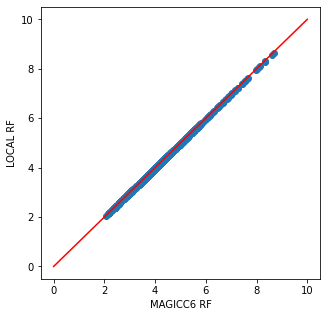

In [78]:
plt.figure(figsize=(5,5))
plt.scatter(MR,LR)
plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),c='red')
plt.xlabel("MAGICC6 RF")
plt.ylabel("LOCAL RF")

## Train multivariate linear regression to fit effect of other gases

In [79]:
dfp['RF3'] = dfp['Diagnostics|MAGICC6|Forcing|CO2'] + dfp['Diagnostics|MAGICC6|Forcing|CH4'] + dfp['Diagnostics|MAGICC6|Forcing|N2O'] 
dfp['RFD'] = dfp['Diagnostics|MAGICC6|Forcing'] - dfp['RF3']

In [80]:
d = dfp[dfp.RF3 < 6][['Diagnostics|MAGICC6|Concentration|CO2','Diagnostics|MAGICC6|Concentration|CH4','Diagnostics|MAGICC6|Concentration|N2O','RFD']].dropna().values
X = d[:,0:3]
y = d[:,3]
rflr = LinearRegression()
rflr.fit(X,y)

def RF_cMAGICC(C,M,N):
    try:
        X_in = np.array([[x,M,N] for x in C])
    except:
        X_in = np.array([[C,M,N]])
    (x,y,z,r) = RF_MAGICC(C,M,N)
    d = rflr.predict(X_in)
    return  d + r

def RF_MAGICC_CORR(C,M,N):
    
    X_in = np.stack((C,M,N),axis=1)
    (x,y,z,r) = RF_MAGICC(C,M,N)
    d = rflr.predict(X_in)
    return  d + r

## Modeling Emission Scenarios and Atmospheric GHG Levels

In [81]:
# Simplify columns for clarity


# TF = Total Emissions FAO
# using total w/out agricultural land change since we are assuming base land use is constant 

fao_emissions_2019['Model:TF'] = fao_emissions_2019['Total emissions without land use']

# A = griculture - as with T, without land change - FAO
fao_emissions_2019['Model:AF'] = fao_emissions_2019['Agriculture total']

# N = non agricultural emissions
fao_emissions_2019['Model:NF'] = fao_emissions_2019['Model:TF'] - fao_emissions_2019['Model:AF']

# L = livestock
fao_emissions_2019.loc['CO2 emissions','Model:LF'] = livestock_data.sum()['Emissions|CO2|Livestock'] 
fao_emissions_2019.loc['CH4 emissions','Model:LF'] = livestock_data.sum()['Emissions|CH4|Livestock'] 
fao_emissions_2019.loc['N2O emissions','Model:LF'] = livestock_data.sum()['Emissions|N2O|Livestock']

# C = crops
fao_emissions_2019['Model:CF'] = fao_emissions_2019['Model:AF'] - fao_emissions_2019['Model:LF']

# Alternative livestock emissions
# LX = livestock emissions from Xu
# CX = crop emissions from Xu

fao_emissions_2019['Model:TX'] = fao_emissions_2019['Model:TF']
for gas in gases:
    fao_emissions_2019.loc['%s emissions' % gas ,'Model:LX'] = xu_animal_emissions[gas]
    fao_emissions_2019.loc['%s emissions' % gas ,'Model:CX'] = xu_plant_emissions[gas]

# AX = Ag Xu
fao_emissions_2019['Model:AX'] = fao_emissions_2019['Model:CX'] + fao_emissions_2019['Model:LX']

# N = non agricultural emissions
fao_emissions_2019['Model:NX'] = fao_emissions_2019['Model:TF'] - fao_emissions_2019['Model:AX']

# SR = soy replacement

fao_emissions_2019.loc['CO2 emissions','Model:SR'] = livestock_data.sum()['Emissions|CO2|Soy Replacement']  
fao_emissions_2019.loc['CH4 emissions','Model:SR'] = livestock_data.sum()['Emissions|CH4|Soy Replacement'] 
fao_emissions_2019.loc['N2O emissions','Model:SR'] = livestock_data.sum()['Emissions|N2O|Soy Replacement'] 

# CR = crop replacement # data from FAO

fao_emissions_2019.loc['CO2 emissions','Model:CR'] = livestock_data.sum()['Emissions|CO2|Crop Replacement']  
fao_emissions_2019.loc['CH4 emissions','Model:CR'] = livestock_data.sum()['Emissions|CH4|Crop Replacement'] 
fao_emissions_2019.loc['N2O emissions','Model:CR'] = livestock_data.sum()['Emissions|N2O|Crop Replacement'] 

# PR = plant replacement # data from Xu et al (2021)

fao_emissions_2019.loc['CO2 emissions','Model:PR'] = livestock_data.sum()['Emissions|CO2|Xu Plant Replacement']  
fao_emissions_2019.loc['CH4 emissions','Model:PR'] = livestock_data.sum()['Emissions|CH4|Xu Plant Replacement'] 
fao_emissions_2019.loc['N2O emissions','Model:PR'] = livestock_data.sum()['Emissions|N2O|Xu Plant Replacement'] 

# Default is PR

for gas in gases:
    fao_emissions_2019.loc['%s emissions' % gas ,'Model:R'] = fao_emissions_2019.loc['%s emissions' %gas,'Model:PR'] 
    



In [82]:
model_years = np.arange(2020,2200)

halflife = {
    'CO2': 1000,
    'CH4': 9,
    'N2O': 115
}

annualdecay = {
    'CO2': 1,
    'CH4': np.power(.5,1/halflife['CH4']),
    'N2O': np.power(.5,1/halflife['N2O'])
}

# this is the naive model

nona = {
    'CO2' : 0,
    'CH4' : (1-annualdecay['CH4']) * 717.76,
    'N2O' : (1-annualdecay['N2O']) * 269.55
}

# this is the closed loop model where non-anthropogenic emissions are adjusted to fit with MAGICC projections

nona_fit = {
    'CO2' : 0,
    'CH4' : 25,
    'N2O' : 1.0 # 1.63 fits historical data
}

# this captures sinks for CO2

to_atm = {
    'CO2' : .5,
    'CH4' : 1,
    'N2O' : 1
}

# CO2 levels are in Gt 

to_Mt = {
    'CO2' : 1000,
    'CH4' : 1,
    'N2O' : 1
}

# CO2 is in ppm 

pp_scale = {
    'CO2' : (1/1000),
    'CH4' : 1,
    'N2O' : 1
}

# to convert where relevant

mw = {
    'CO2' : 44,
    'CH4' : 16,
    'N2O' : 44
}

# starting values 

pp_start = {
    'CO2' : 414.24 , # 2020 data from https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_annmean_mlo.txt
    'CH4' : 1879.10, # 2020 data from https://gml.noaa.gov/webdata/ccgg/trends/ch4/ch4_annmean_gl.txt
    'N2O' : 333.03, # 2020 data from https://gml.noaa.gov/webdata/ccgg/trends/n2o/n2o_annmean_gl.txt
    
}

# which gases to use for Net Zero

netzero_gases = ['CO2','CH4','N2O']
#netzero_gases = ['CO2']

# species/product groups

groups = {
    'bovids' : ['cattle_meat','cow_milk','buffalo_meat','buffalo_milk'],
    'ruminants' : ['cattle_meat','buffalo_meat','goat_meat','sheep_meat','cow_milk','buffalo_milk','goat_milk','sheep_milk'],
    'ruminant_meat' : ['cattle_meat','buffalo_meat','goat_meat','sheep_meat'],
    'ruminant_milk' : ['cow_milk','buffalo_milk','goat_milk','sheep_milk'],
    'poultry' : ['chicken_meat','eggs'],
    'non-ruminants' : ['pig_meat','chicken_meat','eggs']
}

# add all individual products to groups

for cat in commodity_info.Category.unique():
    groups[cat] = [cat]


# Amount of carbon Hayek et al. estimate would be fixed over 30 years with a transformation to a plant only diet

hayek_veg = [153,94,207]
hayek_soil = 63

# Reported in gigatonnes C

c_oc = hayek_veg[0] + hayek_soil
c_oc_low = hayek_veg[1] + hayek_soil
c_oc_high = hayek_veg[2] + hayek_soil
c_oc_nosoil = hayek_veg[0]

# convert gigatonnes C to gigatonnes CO2

co2_oc = c_oc * 44 / 12
co2_oc_low = c_oc_low * 44 / 12
co2_oc_high = c_oc_high * 44 / 12
co2_oc_nosoil = c_oc_nosoil * 44 / 12

land_use_total = livestock_data.sum()['Land Use']

# Scenario Modeling

The core scenario model is simple:

#### Convert emissions to atmospheric levels

CH4 and N2O go straight to atmosphere, CO2 we assume 50% goes to sinks. This approach was confirmed with fits to historical data. The conversion factor is based on mass and number of moles of gas in atmosphere. 

#### Decay of $CH_4$ and $N_{2}O$

There is some variance in estimates for the atmospheric half-lives of $CH_4$ (range 9-12) and $N_{2}O$ (range 115-121). We went with the lower values because these fit historical data better but they do not have significant impacts on the overall conclusions.

#### Non-anthropogenic emissions

Following other models, we assume that there is a non-anthropogenic contribution from $CH_4$ and $N_{2}O$. The values used were determined by fits to historical data.

In [83]:
def RunScenarios(emissions,
                to_Mt = to_Mt,
                mw = mw,
                pp_scale = pp_scale,
                pp_start = pp_start,
                annualdecay = annualdecay,
                to_atm = to_atm,
                nona = nona_fit
                ):
    concentration = {}
    for gas in gases:
        p = emissions[gas] * to_Mt[gas] * 1.0E12 * (1/mw[gas]) * (1/1.8E11) * pp_scale[gas]
        a = np.zeros(len(emissions[gas]))
        a[0] = pp_start[gas]
        for i in range(1,len(a)):
            a[i] = a[i-1] * annualdecay[gas] + p[i-1] * to_atm[gas] + nona[gas]
        concentration[gas] = a
    return concentration

### Setup scenarios

In [84]:
scenarios = pd.DataFrame(data=model_years,columns=['Year'])

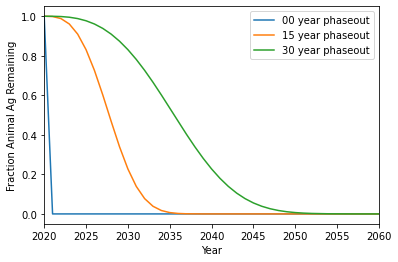

In [85]:
# Consider two general scenarios for phaseout - over 15 and over 30 years
# The curve assumes accelerating rates if transition and thus has an S shape

aa_phaseouts = [0,15,30]
for aa_phaseout in aa_phaseouts:
    scid = 'aa_exponential_phaseout_%02dy' % aa_phaseout
    scenarios[scid] = np.clip( np.exp (-5 * np.power((scenarios.Year-2020)/(aa_phaseout+.001),3)),0,1)
    v = scenarios[scid].values
    scid = 'aa_exponential_phaseout_delta_%02dy' % aa_phaseout
    scenarios[scid] = np.append([0],v[:-1]-v[1:])

plt.plot(scenarios['Year'],scenarios['aa_exponential_phaseout_00y'],label='00 year phaseout')
plt.plot(scenarios['Year'],scenarios['aa_exponential_phaseout_15y'],label='15 year phaseout')
plt.plot(scenarios['Year'],scenarios['aa_exponential_phaseout_30y'],label='30 year phaseout')
plt.xlim(2020,2060)
plt.xlabel("Year")
plt.ylabel("Fraction Animal Ag Remaining")
plt.legend()

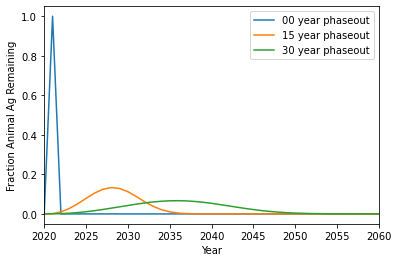

In [86]:
plt.plot(scenarios['Year'],scenarios['aa_exponential_phaseout_delta_00y'],label='00 year phaseout')
plt.plot(scenarios['Year'],scenarios['aa_exponential_phaseout_delta_15y'],label='15 year phaseout')
plt.plot(scenarios['Year'],scenarios['aa_exponential_phaseout_delta_30y'],label='30 year phaseout')
plt.xlim(2020,2060)
plt.xlabel("Year")
plt.ylabel("Fraction Animal Ag Remaining")
plt.legend()

In [87]:
## Consider carbon recovery over 30, 50 and 70 years

###

co2_oc_burnins = [30,50,70]
for co2_oc_burnin in co2_oc_burnins:
    for aa_phaseout in aa_phaseouts:
    
        scid = 'CO2_%02dy_recovery_%02dy_phaseout' % (co2_oc_burnin,aa_phaseout)
        v = scenarios['aa_exponential_phaseout_delta_%02dy' % aa_phaseout]
        scenarios[scid] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]

Text(0, 0.5, 'Annual Carbon Recovery')

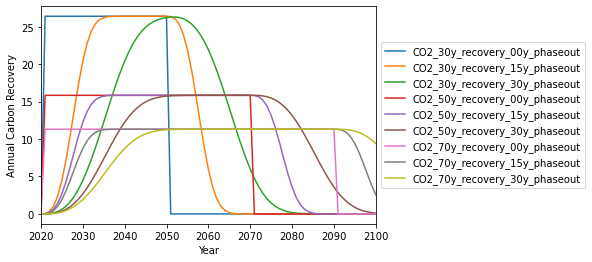

In [88]:
for c in scenarios.columns:
    if c.startswith('CO2'):
        plt.plot(scenarios['Year'],scenarios[c],label=c)
        
plt.xlim(2020,2100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Year")
plt.ylabel("Annual Carbon Recovery")

In [89]:
### Net Zero trajectory
# stable through 2030 then linear decline to 2060

scenarios['net_zero'] = np.clip(1-(scenarios.Year-2030)/20,0,1)

In [90]:
scenario_list = []

In [91]:
## BAU
## assume ongoing emissions remain at 2019 levels

scid = 'BAU'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:TF']

In [92]:
## Baseline
## assume 0 emissions

scid = 'Baseline'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = 0

In [93]:
## Baseline
## assume 0 emissions of individual gases

for elim_gas in gases:
    scid = 'Baseline_%s' % elim_gas
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        if gas == elim_gas:        
            scenarios[emid] = 0
        else:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:TF']
        

In [94]:
## Net Zero
## assume non-agricultural emissions are steady through 2030 then drop linearly to 0 in 2060
 
scid = 'Net Zero'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = 0
    scenarios[emid] += (gas not in netzero_gases) * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
    scenarios[emid] += (gas in netzero_gases) * scenarios['net_zero'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF'] 
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:AF']

In [95]:
## Net Zero
## assume non-agricultural emissions are steady through 2030 then drop linearly to 0 in 2060

netzero_gases = ['CO2']
scid = 'Net Zero|CO2'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = 0
    scenarios[emid] += (gas not in netzero_gases) * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
    scenarios[emid] += (gas in netzero_gases) * scenarios['net_zero'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF'] 
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:AF']
    
netzero_gases = ['CO2','CH4','N2O']

In [96]:
aa_phaseouts

[0, 15, 30]

In [97]:
co2_oc_burnins

[30, 50, 70]

In [98]:
recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = recovered_land / land_use_total

netzero_gases = ['CO2']

aa_scenarios = aa_phaseouts
cr_scenarios = co2_oc_burnins
nz_scenarios = ['BAU','NZ']
rp_scenarios = ['PR','CR','SR']
em_scenarios = ['F','X']
re_scenarios = [0,25,50,75,90,100]

lists = [aa_scenarios,cr_scenarios,re_scenarios,nz_scenarios,rp_scenarios,em_scenarios]

for (aas,crs,res,nzs,rps,ems) in itertools.product(*lists):
    
    scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aas,crs,res,nzs,rps,ems)
    scenario_list.append(scid)
    
    for gas in gases:
        
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] = 0
        
        # non-ag emissions
        
        if nzs == 'BAU':
            scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:N%s' % ems]
        elif nzs == 'NZ':
            scenarios[emid] += (gas not in netzero_gases) * fao_emissions_2019.loc['%s emissions' % gas]['Model:N%s' % ems]
            scenarios[emid] += (gas in netzero_gases) * scenarios['net_zero'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:N%s' % ems] 

        # crops
        
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C%s' % ems]
        
        # livestock
        
        aaid = 'aa_exponential_phaseout_%02dy' % aas
        scenarios[emid] += scenarios[aaid] * fao_emissions_2019.loc['%s emissions' % gas]['Model:L%s' % ems]
        scenarios[emid] += (1 - scenarios[aaid]) * fao_emissions_2019.loc['%s emissions' % gas]['Model:%s' %rps]
        
        crid = 'CO2_%02dy_recovery_%02dy_phaseout' % (crs,aas)
        
        scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios[crid] * res / 100
        
netzero_gases = ['CO2','CH4','N2O']

In [99]:
aadef = 15
crdef = 30
redef = 100
nzdef = 'BAU'
rpdef = 'CR'
emdef = 'F'


In [100]:
phaseout_scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,nzdef,rpdef,emdef)
phaseout_nz_scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,"NZ",rpdef,emdef)
elimination_scid = "PH00_CR%02d_RP%03d_%s_%s_%s" % (crdef,redef,nzdef,rpdef,emdef)

In [101]:
## 15 Year Elimination and Phaseout of different combinations of effects

for tag,gas_reduce in [
    ['CO2',['CO2']],
    ['CH4',['CH4']],
    ['N2O',['N2O']],
    ['CO2_CH4',['CO2','CH4']],
    ['CO2_CH4_N2O',['CO2','CH4','N2O']],
    ['CO2_CH4_N2O_CR',['CO2','CH4','N2O','CR']],
    ['CR_Only',['CR']],
    
]:

    aap = 'aa_exponential_phaseout_15y'
    crp = 'CO2_30y_recovery_15y_phaseout'

    scid = 'Phaseout_Breakdown_%s' % tag
    scenario_list.append(scid)
    
    recovered_land = livestock_data.sum()['Land Use|Recovered']
    cr_rat = recovered_land / land_use_total

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)

        if gas in gas_reduce:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
            scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
            scenarios[emid] += scenarios[aap] * fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
            scenarios[emid] += (1 - scenarios[aap]) * fao_emissions_2019.loc['%s emissions' % gas]['Model:%s' % rpdef]
        else:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:TF']
            
        if 'CR' in gas_reduce:
            scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios[crp] 

    aap = 'aa_exponential_phaseout_00y'
    crp = 'CO2_30y_recovery_00y_phaseout'
            
    scid = 'Elimination_Breakdown_%s' % tag
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)

        if gas in gas_reduce:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
            scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
            scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:%s' % rpdef]
        else:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:TF']
            
        if 'CR' in gas_reduce:
            scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios[crp] 

In [102]:
## Different Hayek scenarios

aap = 'aa_exponential_phaseout_15y'
crp = 'CO2_30y_recovery_15y_phaseout'

scid = 'Phaseout|Hayek High'
scenario_list.append(scid)

recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = (co2_oc_high / co2_oc) * recovered_land / land_use_total

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
    scenarios[emid] += scenarios[aap] * fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
    scenarios[emid] += (1 - scenarios[aap]) * fao_emissions_2019.loc['%s emissions' % gas]['Model:%s' % rpdef]
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios[crp] 
    
scid = 'Phaseout|Hayek Low'
scenario_list.append(scid)

recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = (co2_oc_low / co2_oc) * recovered_land / land_use_total

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
    scenarios[emid] += scenarios[aap] * fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
    scenarios[emid] += (1 - scenarios[aap]) * fao_emissions_2019.loc['%s emissions' % gas]['Model:%s' % rpdef]
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios[crp] 

scid = 'Phaseout|Hayek No Soil'
scenario_list.append(scid)

recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = (co2_oc_nosoil / co2_oc) * recovered_land / land_use_total

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
    scenarios[emid] += scenarios[aap] * fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
    scenarios[emid] += (1 - scenarios[aap]) * fao_emissions_2019.loc['%s emissions' % gas]['Model:%s' % rpdef]
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios[crp] 

In [103]:
## Eliminate and Phaseout of Product Categories

netzero_gases = ['CO2']

for group in groups:
    
    ## Elimination
        
    aap = 'aa_exponential_phaseout_00y'
    crp = 'CO2_30y_recovery_00y_phaseout'
    
    dfs = livestock_data[livestock_data.Category.isin(groups[group])].sum(numeric_only=True,axis=0)
    lu_frac = dfs['Land Use|Recovered'] / livestock_data.sum()['Land Use']
    
    scid = 'Elimination|%s' % group
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] =  fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
        scenarios[emid] -= dfs['Emissions|%s|Livestock' % gas]
        scenarios[emid] += dfs['Emissions|%s|Crop Replacement' % gas]
        scenarios[emid] -= (gas == "CO2") * lu_frac * scenarios[crp] 
        
    scid = 'Elimination|No CR|%s' % group
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] =  fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
        scenarios[emid] -= dfs['Emissions|%s|Livestock' % gas]
        scenarios[emid] += dfs['Emissions|%s|Crop Replacement' % gas]
        
    scid = 'Elimination|Only CR|%s' % group
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] =  fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
        scenarios[emid] -= (gas == "CO2") * lu_frac * scenarios[crp] 
        
    scid = 'Elimination|Net Zero|%s' % group
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] = 0
        scenarios[emid] += (gas not in netzero_gases) * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
        scenarios[emid] += (gas in netzero_gases) * scenarios['net_zero'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF'] 
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
        scenarios[emid] -= dfs['Emissions|%s|Livestock' % gas]
        scenarios[emid] += dfs['Emissions|%s|Crop Replacement' % gas]
        scenarios[emid] -= (gas == "CO2") * lu_frac * scenarios[crp] 
    
    
    ## Phaseout
    
    aap = 'aa_exponential_phaseout_15y'
    crp = 'CO2_30y_recovery_15y_phaseout'
    
    scid = 'Phaseout|%s' % group
    scenario_list.append(scid)
    
    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] =  fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
        scenarios[emid] -= (1 - scenarios[aap])  * dfs['Emissions|%s|Livestock' % gas]
        scenarios[emid] += (1 - scenarios[aap]) * dfs['Emissions|%s|Crop Replacement' % gas]
        scenarios[emid] -= (gas == "CO2") * lu_frac * scenarios[crp] 
        
    scid = 'Phaseout|Net Zero|%s' % group
    scenario_list.append(scid)
    
    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] = 0
        scenarios[emid] += (gas not in netzero_gases) * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']
        scenarios[emid] += (gas in netzero_gases) * scenarios['net_zero'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:NF']   
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:CF']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:LF']
        scenarios[emid] -= (1 - scenarios[aap])  * dfs['Emissions|%s|Livestock' % gas]
        scenarios[emid] += (1 - scenarios[aap])  * dfs['Emissions|%s|Crop Replacement' % gas]
        scenarios[emid] -= (gas == "CO2") * lu_frac * scenarios[crp] 
        
        
netzero_gases = ['CO2','CH4','N2O']

## Run Scenarios

In [104]:
scenarios = scenarios.reset_index()

In [105]:
passed = []

for scen in scenario_list:
        em = {}
        for gas in gases:
            em[gas] = scenarios['Emissions|%s|%s' % (gas,scen)].fillna(0).values

        p = RunScenarios(em)
        for gas in gases:
            scenarios['Concentration|%s|%s' % (gas,scen)] = p[gas]

        rf = RF_MAGICC(p['CO2'],p['CH4'],p['N2O'])
        scenarios['RF|%s' % scen] = rf[3]
        scenarios['CRF|%s' % scen] = np.cumsum(scenarios['RF|%s' % scen].values) 
        scenarios['RFD|%s' % scen] =  scenarios['RF|%s' % scen] -  scenarios['RF|BAU']
        scenarios['CRFD|%s' % scen] = np.cumsum(scenarios['RFD|%s' % scen].values) 
        
        scenarios['RFY|%s' % scen] = rf[3] * (5.1E+14/1E+12)
        scenarios['CRFY|%s' % scen] = np.cumsum(scenarios['RFY|%s' % scen].values) 
        scenarios['RFDY|%s' % scen] =  scenarios['RFY|%s' % scen] -  scenarios['RFY|BAU']
        scenarios['CRFDY|%s' % scen] = np.cumsum(scenarios['RFDY|%s' % scen].values) 

        rf = RF_MAGICC_CORR(p['CO2'],p['CH4'],p['N2O'])
        scenarios['RFC|%s' % scen] = rf 
        scenarios['CRFC|%s' % scen] = np.cumsum(scenarios['RFC|%s' % scen].values) 
        scenarios['RFCD|%s' % scen] =  scenarios['RFC|%s' % scen] -  scenarios['RFC|BAU']
        scenarios['CRFCD|%s' % scen] = np.cumsum(scenarios['RFCD|%s' % scen].values)
        
        scenarios['RFCY|%s' % scen] = rf[3] * (5.1E+14/1E+12)  
        scenarios['CRFCY|%s' % scen] = np.cumsum(scenarios['RFCY|%s' % scen].values) 
        scenarios['RFDCY|%s' % scen] =  scenarios['RFCY|%s' % scen] -  scenarios['RFCY|BAU']
        scenarios['CRFDCY|%s' % scen] = np.cumsum(scenarios['RFDCY|%s' % scen].values) 

## Calibration Scenarios

We calculate an annualized CO2 equivalent for cumulative RF changes by comparison to scenarios in which we start with BAU and remove CO2 emissions in different levels and then do a calibration to observed RF differences.

In [106]:
with np.errstate(divide='ignore',invalid='ignore'): 
    calib_scenarios = pd.DataFrame(data=model_years,columns=['Year'])
    calib_scenario_list = []


    ## BAU

    calib_scenario_list.append('BAU')

    for gas in gases:
        calib_scenarios['Emissions|%s|BAU' % gas] = fao_emissions_2019.loc['%s emissions' % gas]['Model:TF']


    gtsteps = np.arange(1,50)

    for i in gtsteps:
        scenid = 'BAU_m%02dGT' % i
        calib_scenario_list.append(scenid)
        for gas in gases:
            calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

        # account for 2020
        v = np.ones(len(calib_scenarios))
        v[0] = 0

        calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i

    mtsteps = np.arange(10,1000,10)

    for i in mtsteps:
        scenid = 'BAU_m%04dMT' % i
        calib_scenario_list.append(scenid)
        for gas in gases:
            calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

        # account for 2020
        v = np.ones(len(calib_scenarios))
        v[0] = 0

        calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i/1000

    ktsteps = np.arange(100,1000,100)

    for i in ktsteps:
        scenid = 'BAU_m%04dkT' % i
        calib_scenario_list.append(scenid)
        for gas in gases:
            calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

        # account for 2020
        v = np.ones(len(calib_scenarios))
        v[0] = 0

        calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i/1000000



    for scen in calib_scenario_list:
        em = {}
        for gas in gases:
            em[gas] = calib_scenarios['Emissions|%s|%s' % (gas,scen)]

        p = RunScenarios(em)
        for gas in gases:
            calib_scenarios['Concentration|%s|%s' % (gas,scen)] = p[gas]

        rf = RF_MAGICC(p['CO2'],p['CH4'],p['N2O'])
        calib_scenarios['RF|%s' % scen] = rf[3]
        calib_scenarios['RFD|%s' % scen] =  calib_scenarios['RF|%s' % scen] -  calib_scenarios['RF|BAU']
        calib_scenarios['CRFD|%s' % scen] = np.cumsum(calib_scenarios['RFD|%s' % scen].values) 

        rf = RF_MAGICC_CORR(p['CO2'],p['CH4'],p['N2O'])
        calib_scenarios['RFC|%s' % scen] = rf
        calib_scenarios['RFCD|%s' % scen] =  calib_scenarios['RFC|%s' % scen] -  calib_scenarios['RFC|BAU']
        calib_scenarios['CRFCD|%s' % scen] = np.cumsum(calib_scenarios['RFCD|%s' % scen].values)   

    calib_scenarios = calib_scenarios.set_index('Year')

    coc_calibrations = {
    }

    for year in np.arange(2020,2200):

        x = []
        y = []

        r = calib_scenarios.loc[year]
        for i in gtsteps:
            x.append(i)
            y.append(r['CRFD|BAU_m%02dGT' % i])
        for i in mtsteps:
            x.append(i/1000)
            y.append(r['CRFD|BAU_m%04dMT' % i])
        for i in ktsteps:
            x.append(i/1000000)
            y.append(r['CRFD|BAU_m%04dkT' % i])

        f = interp1d(y,x)
        try:
            pf = np.polyfit(y,x,2)
            z = np.poly1d(pf)
        except:
            z = np.poly1d([0])

        x = []
        y = []

        r = calib_scenarios.loc[year]
        for i in gtsteps:
            x.append(i)
            y.append(r['CRFCD|BAU_m%02dGT' % i])
        for i in mtsteps:
            x.append(i/1000)
            y.append(r['CRFCD|BAU_m%04dMT' % i])
        for i in ktsteps:
            x.append(i/1000000)
            y.append(r['CRFCD|BAU_m%04dkT' % i])

        fci = interp1d(y,x)

        try:
            pfc = np.polyfit(y,x,2)
            zc = np.poly1d(pfc)
        except:
            zc = np.poly1d([0])

        coc_calibrations[year] = [f,z,fci,zc]


In [107]:
scenarios = scenarios.set_index('Year')

### Apply calibration functions

In [108]:
def compute_aco2eq(s):
    r = []
    for year in s.index:
        if year in coc_calibrations:
            [f,z,fc,zc] = coc_calibrations[year]
            try:
                v = f(s[year])
                r.append(float(v))
            except:
                v = z(s[year])
                r.append(float(v))
        else:
            r.append(0)    
    return r

def compute_aco2eqc(s):
    r = []
    for year in s.index:
        if year in coc_calibrations:
            [f,z,fc,zc] = coc_calibrations[year]
            try:
                v = fc(s[year])
                r.append(float(v))
            except:
                v = zc(s[year])
                r.append(float(v))
        else:
            r.append(0)    
    return r

In [109]:
for scen in scenario_list:
    scenarios['ACO2EQ|%s' % scen] = compute_aco2eq(scenarios['CRFD|%s' % scen])
    scenarios['COC|%s' % scen] = (scenarios.index - 2021) * scenarios['ACO2EQ|%s' % scen]
    scenarios['ACO2EQC|%s' % scen] = compute_aco2eqc(scenarios['CRFCD|%s' % scen]) 
    scenarios['COCC|%s' % scen] = (scenarios.index - 2021) * scenarios['ACO2EQC|%s' % scen]
    

for scen in calib_scenario_list:
    calib_scenarios['ACO2EQ|%s' % scen] = compute_aco2eq(calib_scenarios['CRFD|%s' % scen])
    calib_scenarios['COC|%s' % scen] = (calib_scenarios.index - 2021) * calib_scenarios['ACO2EQ|%s' % scen]
    calib_scenarios['ACO2EQC|%s' % scen] = compute_aco2eqc(calib_scenarios['CRFCD|%s' % scen]) 
    calib_scenarios['COCC|%s' % scen] = (calib_scenarios.index - 2021) * calib_scenarios['ACO2EQC|%s' % scen]    



## Product Equivalents

In [110]:
livestock_data['Dress Factor'] = 1.0
meat_cats = [c for c in livestock_data.Category.unique() if 'meat' in c]
df = livestock_data[livestock_data.Category.isin(meat_cats) ]
livestock_data.loc[df.index,'Dress Factor'] = 1.5
livestock_data['Dress Consumption'] = livestock_data['Consumption'] / livestock_data['Dress Factor']

In [111]:
# Emission Intensities
# per kg product

miles_per_gallon = 22.2
km_per_gallon = miles_per_gallon / 0.621371
km_per_liter = km_per_gallon / 3.78541

co2_per_gallon = 8.8
co2_per_liter = co2_per_gallon / 3.78541

km_per_kgco2 = km_per_liter / co2_per_liter

# Use data from Bieker LCA 
# https://theicct.org/publications/global-LCA-passenger-cars-jul2021

lca_kgco2_per_km = .254
lca_km_per_kgco2 = 1 / lca_kgco2_per_km 

for group in groups:
    for scen in ['Elimination|%s' % group,'Phaseout|%s' % group, 'Elimination|No CR|%s' % group,'Elimination|Only CR|%s' % group]:
        
        df = livestock_data[livestock_data.Category.isin(groups[group])]
        scenarios['EI_perunit|%s' % scen] = (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * df['Dress Consumption'].sum())
        scenarios['DD_perunit|%s' % scen] = scenarios['EI_perunit|%s' % scen] * lca_km_per_kgco2 
        scenarios['EI_perprotein|%s' % scen] = (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * df['Protein Consumption'].sum())
        scenarios['DD_perprotein|%s' % scen] = scenarios['EI_perprotein|%s' % scen] * lca_km_per_kgco2
        

In [112]:
scenarios.to_csv("Outputs/Scenarios.csv")
calib_scenarios.to_csv("Outputs/Calibration_Scenarios.csv")

## Emissions and Land Carbon Opportunity Cost

We extend the concept of COC (Hayek et al., 2021) to include both emissions and land use changes. We define the “emissions and land carbon opportunity cost” (ELCOC) of dietary interventions as the cumulative reduction in CO2 emissions necessary to reduce the RF projected in a BAU scenario in 2100 to the RF projected following intervention.  

We define the combined emissions and land carbon opportunity cost (ELCOC) of animal agriculture as $2\Delta C$ where:
  
$RF(C_{BAU}-\Delta C,M_{BAU},N_{BAU})=RF(C_{POD},M_{POD},N_{POD})$  

The factor of 2 accounts for the half of $CO_2$ emissions that go to terrestrial sinks.


In [113]:
proj_end = scenarios.loc[2100]

xl = 300
xh = 700
x = np.linspace(xl,xh,100000)

CB = proj_end['Concentration|CO2|BAU']
MB = proj_end['Concentration|CH4|BAU']
NB = proj_end['Concentration|N2O|BAU']

xd = x - CB
xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
x_R = RF_cMAGICC(x,MB,NB)

data = []

for scid in scenario_list:
    rft = proj_end['RFC|%s' % scid ]
    xn = xe[np.argmin(np.abs(x_R-rft))]
    xnd = xd[np.argmin(np.abs(x_R-rft))]
    data.append([scid,rft,xnd,xn])    
    
rft = 2.6
xn = xe[np.argmin(np.abs(x_R-rft))]
xnd = xd[np.argmin(np.abs(x_R-rft))]
data.append(['RF2.6',rft,xnd,xn])

rft = 1.9
xn = xe[np.argmin(np.abs(x_R-rft))]
xnd = xd[np.argmin(np.abs(x_R-rft))]
data.append(['RF1.9',rft,xnd,xn])

elcoc = pd.DataFrame(data=data,columns=['Target','RF','PPD','ELCOC'])
elcoc['ELCOC'] = np.round(elcoc.ELCOC,2)
elcoc = elcoc.set_index(['Target'])

In [114]:
elcoc.sort_values('ELCOC')

,RF,PPD,ELCOC
Target,,,
Baseline,1.306648,-286.548873,-4.54
RF1.9,1.900000,-250.960517,-3.98
PH00_CR70_RP100_NZ_CR_F,2.158308,-234.264350,-3.71
PH00_CR50_RP100_NZ_CR_F,2.158308,-234.264350,-3.71
PH00_CR30_RP100_NZ_CR_F,2.158308,-234.264350,-3.71
...,...,...,...
Phaseout|duck_meat,4.918556,-0.422012,-0.01
Elimination|Only CR|goat_milk,4.920248,-0.242010,-0.00
Elimination|Only CR|duck_meat,4.921625,-0.098009,-0.00


In [115]:
elcoc.sort_values('ELCOC',ascending=False)

,RF,PPD,ELCOC
Target,,,
BAU,4.922540,0.001992,0.00
Elimination|Only CR|duck_meat,4.921625,-0.098009,-0.00
Elimination|Only CR|sheep_milk,4.921332,-0.130009,-0.00
Elimination|Only CR|goat_milk,4.920248,-0.242010,-0.00
Elimination|duck_meat,4.918231,-0.458012,-0.01
...,...,...,...
PH00_CR50_RP100_NZ_CR_F,2.158308,-234.264350,-3.71
PH00_CR70_RP100_NZ_CR_F,2.158308,-234.264350,-3.71
PH00_CR30_RP100_NZ_CR_F,2.158308,-234.264350,-3.71


## Land Use if Western Diet Extended to Whole Planet

In [116]:
diet_countries = country_group[country_group['Country Group'] == "OECD"].Country

In [117]:
pop = pd.read_csv("FAOSTAT/Filtered/Population_E_All_Data_(Normalized).csv")

diet_pop = pop[(pop.Year == 2018) & (pop.Area.isin(diet_countries))].groupby('Element').sum().loc['Total Population - Both sexes']['Value'] * 1000
diet_pop_landuse = livestock_data[livestock_data.Area.isin(diet_countries)].sum(numeric_only=True)['Land Use']

world_pop = pop[(pop.Year == 2018) & (pop.Area.isin(fao_countries))].groupby('Element').sum().loc['Total Population - Both sexes']['Value'] * 1000
world_pop_landuse = livestock_data[livestock_data.Area.isin(fao_countries)].sum(numeric_only=True)['Land Use']

scaled_land_use = diet_pop_landuse * world_pop / diet_pop
print ("If world had OECD diet an additional %.2f Mkm^2 of land would be needed for livestock" % (scaled_land_use - world_pop_landuse))

extra_land_use = scaled_land_use - world_pop_landuse

If world had OECD diet an additional 35.44 Mkm^2 of land would be needed for livestock


###  Table 1

In [118]:
table1 = livestock_data.groupby('Category').sum().reset_index().merge(commodity_info,on='Category')

In [119]:
data = []

r = scenarios.loc[2100]
for cat in list(table1.Category):
    data.append([cat,
                 -r['ACO2EQ|Elimination|%s' %cat],
                 -r['EI_perunit|Elimination|%s' %cat],
                 -r['EI_perprotein|Elimination|%s' %cat],
                 r['DD_perunit|Elimination|%s' %cat],
                ])

df = pd.DataFrame(data=data, columns=['Category','ACO2EQ','EI_perunit','EI_perprotein','DD'])

In [120]:
table1 = table1.merge(df,on="Category")

In [121]:
table1 = table1.set_index('Category')

In [122]:
table1.loc['buffalo_meat','Order'] = 1
table1.loc['cattle_meat','Order'] = 2
table1.loc['sheep_meat','Order'] = 3
table1.loc['goat_meat','Order'] = 4
table1.loc['pig_meat','Order'] = 5
table1.loc['chicken_meat','Order'] = 6
table1.loc['duck_meat','Order'] = 7
table1.loc['buffalo_milk','Order'] = 8
table1.loc['cow_milk','Order'] = 9
table1.loc['sheep_milk','Order'] = 10
table1.loc['goat_milk','Order'] = 11
table1.loc['eggs','Order'] = 12

table1 = table1.reset_index().sort_values(['Order'])

In [123]:
table1['Emissions|CO2'] = table1['Emissions|CO2|Livestock'] * 1000
table1['Emissions|CH4'] = table1['Emissions|CH4|Livestock']
table1['Emissions|N2O'] = table1['Emissions|N2O|Livestock']

In [124]:
table1 = table1[['Species Name', 'Product Type', 'Domestic Production', 'Protein Consumption',
                  'Emissions|CO2', 'Emissions|CH4', 'Emissions|N2O', 'Land Use', 
                'ACO2EQ', 'EI_perunit', 'EI_perprotein','DD']]

In [125]:
table1.to_csv("Outputs/Table1.csv", index=False)

In [126]:
table1

,Species Name,Product Type,Domestic Production,Protein Consumption,Emissions|CO2,Emissions|CH4,Emissions|N2O,Land Use,ACO2EQ,EI_perunit,EI_perprotein,DD
0,Buffalo,Meat,4290212.0,619200.03918,28.63585,5.000432,0.198579,1.015488,-1.012349,-353.950578,-1634.929932,1393.506213
2,Cattle,Meat,67893363.0,10435590.303447,236.0449,49.301492,2.41195,17.113445,-13.479823,-297.775341,-1291.716405,1172.343864
10,Sheep,Meat,9648245.0,1354398.31527,31.669994,5.021248,0.325173,2.515143,-1.832874,-286.035114,-1353.275681,1126.122497
7,Goats,Meat,6128372.0,821383.1808,20.634666,3.339641,0.113604,0.823557,-0.733885,-180.124450,-893.474454,709.151378
9,Pigs,Meat,110102495.0,14447437.94,278.161777,7.188181,0.615821,1.589902,-1.715769,-23.389666,-118.759409,92.085298
3,Chickens,Meat,123898557.0,17393439.8475,305.765938,0.293432,0.52056,1.253396,-0.966723,-11.880171,-55.579747,46.772326
5,Ducks,Meat,7363110.0,1044797.0325,26.715672,0.023536,0.049262,0.074346,-0.076746,-15.701039,-73.455151,61.815113
1,Buffalo,Milk,133752296.0,4510016.642341,118.887064,10.872296,0.445477,1.190395,-1.696196,-12.681622,-376.095299,49.927646
4,Cattle,Milk,712883270.0,23889272.741518,337.763667,37.628573,1.775197,6.32845,-6.859261,-9.681693,-287.127254,38.116902
11,Sheep,Milk,10172020.0,624047.912572,9.696341,1.724319,0.1215,0.090531,-0.240455,-23.372307,-385.315707,92.016957


In [127]:
table1['DD_mpp'] = table1['DD'] * 0.621371 * 0.453592

In [128]:
table1

,Species Name,Product Type,Domestic Production,Protein Consumption,Emissions|CO2,Emissions|CH4,Emissions|N2O,Land Use,ACO2EQ,EI_perunit,EI_perprotein,DD,DD_mpp
0,Buffalo,Meat,4290212.0,619200.03918,28.63585,5.000432,0.198579,1.015488,-1.012349,-353.950578,-1634.929932,1393.506213,392.758214
2,Cattle,Meat,67893363.0,10435590.303447,236.0449,49.301492,2.41195,17.113445,-13.479823,-297.775341,-1291.716405,1172.343864,330.423846
10,Sheep,Meat,9648245.0,1354398.31527,31.669994,5.021248,0.325173,2.515143,-1.832874,-286.035114,-1353.275681,1126.122497,317.396404
7,Goats,Meat,6128372.0,821383.1808,20.634666,3.339641,0.113604,0.823557,-0.733885,-180.124450,-893.474454,709.151378,199.873546
9,Pigs,Meat,110102495.0,14447437.94,278.161777,7.188181,0.615821,1.589902,-1.715769,-23.389666,-118.759409,92.085298,25.954141
3,Chickens,Meat,123898557.0,17393439.8475,305.765938,0.293432,0.52056,1.253396,-0.966723,-11.880171,-55.579747,46.772326,13.182729
5,Ducks,Meat,7363110.0,1044797.0325,26.715672,0.023536,0.049262,0.074346,-0.076746,-15.701039,-73.455151,61.815113,17.422522
1,Buffalo,Milk,133752296.0,4510016.642341,118.887064,10.872296,0.445477,1.190395,-1.696196,-12.681622,-376.095299,49.927646,14.072053
4,Cattle,Milk,712883270.0,23889272.741518,337.763667,37.628573,1.775197,6.32845,-6.859261,-9.681693,-287.127254,38.116902,10.743208
11,Sheep,Milk,10172020.0,624047.912572,9.696341,1.724319,0.1215,0.090531,-0.240455,-23.372307,-385.315707,92.016957,25.934879


In [129]:
for gas in gases:
    print (gas,1000 * table1.loc[2]['Emissions|%s' % gas] / (table1.loc[2]['Domestic Production']))

CO2 0.0034767006564605848
CH4 0.0007261607055854539
N2O 3.552555800155643e-05


## Numbers from Text

In [130]:
def significant_digits(n,precision=2):
    
    oom = math.floor(math.log(abs(n), 10))
    return round(n,-oom + (precision - 1))
    

In [131]:
def roundformat(n,precision):
    r = significant_digits(n,precision)
    if r == int(r):
        return "%d" % r
    else:
        return ("%f" % r).rstrip('0').rstrip('.')
    

In [132]:
nft = pd.DataFrame(columns=['Name','Value','Unit','Section'])
nft = nft.set_index('Name')

In [133]:
# add nft variable 

def add_nft(n,v,unit = '',section='',nft = nft):
    nft.loc[n,'Value'] = v
    nft.loc[n,'Unit'] = unit
    nft.loc[n,'Section'] = section

In [134]:
# Title

variable = 100*scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid] / fao_emissions_2019['Model:TF']['CO2 emissions']

add_nft("CO2 Offset %",variable,"%","Title")

In [135]:
# Abstract

variable = scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid]
add_nft("ACO2eq Phaseout",variable,"Gt/year","Abstract")

In [136]:
# Introduction

In [137]:
# Hayek COC

From Hayek 2020: https://www.nature.com/articles/s41893-020-00603-4

Here we quantify the total carbon opportunity cost of animal agricultural production to be 152.5 (94.2–207.1) gigatons of carbon (GtC) in living plant biomass across all continents and biomes. 

We approximated the potential for CO2 removal in soil and litter as an additional 63 GtC (Supplementary Table 4). 

In [138]:
hayek_coc_c = 152.5 + 63
hayek_coc_co2 = hayek_coc_c * (44/12)

add_nft("Hayek COC", hayek_coc_co2, "Gt CO2", "Introduction")

In [139]:
# Strassburg COC

Strassburg 2021 https://www.nature.com/articles/s41586-020-2784-9 do not explicitly give a total number in the text, but Figure 2B shows the 100% completion line exceeding 900 Gt. We do not use this number in calculations, rather it serves as a semi-independent confirmation of the value from Hayek that we do use.

In [140]:
# Results

In [141]:
# Emissions from animal agriculture

In [142]:
add_nft("Livestock Emissions|CO2", fao_emissions_2019['Model:LF']['CO2 emissions'], "Gt/year", "Results")
add_nft("Livestock Emissions|CH4", fao_emissions_2019['Model:LF']['CH4 emissions'], "Mt/year", "Results")
add_nft("Livestock Emissions|N2O", fao_emissions_2019['Model:LF']['N2O emissions'], "Mt/year", "Results")

In [143]:
# Emissions from animal agriculture as percentage of total

In [144]:
for gas in ['CO2','CH4','N2O']:
    add_nft("Livestock Emissions Percent|%s" % gas, 100 * (fao_emissions_2019['Model:LF'] / fao_emissions_2019['Model:TF'])['%s emissions' % gas],"%","Results")
    

In [145]:
variable = .001 * (fao_emissions_2019['Model:LF']['CO2 emissions'] + 34 * fao_emissions_2019['Model:LF']['CH4 emissions'] + 298 * fao_emissions_2019['Model:LF']['N2O emissions'])


add_nft("Livestock Emissions CO2eq",variable,"Gt CO2eq","Results")
        

In [146]:
# RF in 2100

In [147]:
add_nft("RF2100 BAU", scenarios.loc[2100]['RFC|BAU'], "Wm-2", "Results|RF")
add_nft("RF2100 Phaseout", scenarios.loc[2100]['RFC|%s' % phaseout_scid], "Wm-2", "Results|RF")
add_nft("ELCOC Phaseout",1000 * elcoc.loc[phaseout_scid]['ELCOC'],"Gt","Results|RF")
add_nft("ELCOC Phaseout Years",-elcoc.loc[phaseout_scid]['ELCOC']  * 1000 / fao_emissions_2019['Model:TF']['CO2 emissions'],"Years","Results|RF")

In [148]:
# 2C and 1.5C scenarios

add_nft("PPM BAU to RF2.6", -elcoc.loc['RF2.6']['PPD'], "ppm CO2", "Results:RF")
add_nft("PPM RF2.6 to RF1.9", (elcoc.loc['RF2.6'] - elcoc.loc['RF1.9'])['PPD'], "ppm CO2", "Results:RF")
add_nft("ELCOC BAU to RF2.6", -1000*elcoc.loc['RF2.6']['ELCOC'], "Gt CO2", "Results:RF")
add_nft("ELCOC RF2.6 to RF1.9",1000*((elcoc.loc['RF2.6'] - elcoc.loc['RF1.9'])['ELCOC']),"Gt CO2","Results:RF")

In [149]:
# Phaseout relative to 2.6 and 1.9

In [150]:
add_nft("Phaseout Contribution to RF2.6", 100 * (elcoc.loc[phaseout_scid]/elcoc.loc['RF2.6'])['ELCOC'], "%", "Results|RF")
add_nft("Phaseout Contribution to RF1.9", 100 *(elcoc.loc[phaseout_scid]/elcoc.loc['RF1.9'])['ELCOC'], "%", "Results|RF")

In [151]:
# ACO2eq

In [152]:
#add_nft("ACO2eq Phaseout ", scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid], "Gt CO2/year", "Results|ACO2eq")
add_nft("ACO2eq Phaseout Percent", 100 * scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid] / fao_emissions_2019['Model:TF']['CO2 emissions'], "%", "Results|ACO2eq")

In [153]:
# Comparison to Net Zero 2050

add_nft("ACO2eq Net Zero Non Ag", scenarios.loc[2100]['ACO2EQ|Net Zero'], "Gt/year", "Results|ACO2eq")

In [154]:
add_nft("ACO2eq Net Zero CO2 2050",scenarios.loc[2100]['ACO2EQ|Net Zero|CO2'],"Gt/year", "Results|ACO2eq")

In [155]:
# Product-specific numbers


v = 100 * scenarios.loc[2100]['ACO2EQ|%s' % "Phaseout|cattle_meat"] / scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid]
add_nft("Effect % of Beef Phaseout",v,'%','Results|Products')
v = 100 * scenarios.loc[2100]['ACO2EQ|%s' % "Phaseout|cow_milk"] / scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid]
add_nft("Effect % of Cow Milk Phaseout",v,'%','Results|Products')
v = 100 * scenarios.loc[2100]['ACO2EQ|%s' % "Phaseout|bovids"] / scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid]
add_nft("Effect % of Bovid Phaseout",v,'%','Results|Products')
v = 100 * scenarios.loc[2100]['ACO2EQ|%s' % "Phaseout|ruminants"] / scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid]
add_nft("Effect % of Ruminant Phaseout",v,'%','Results|Products')


In [156]:
# Emissions Intensities

add_nft("EI_perunit|cattle meat",scenarios.loc[2100]['EI_perunit|Elimination|cattle_meat'],'kg CO2/kg product','Results|EI')
add_nft("EI_perunit|Emissions|cattle meat",scenarios.loc[2100]['EI_perunit|Elimination|No CR|cattle_meat'],'kg CO2/kg product','Results|EI')
add_nft("EI_perunit|Carbon Recovery|cattle meat",scenarios.loc[2100]['EI_perunit|Elimination|Only CR|cattle_meat'],'kg CO2/kg product','Results|EI')

In [157]:
v = scenarios.loc[2100]['EI_perunit|Elimination|No CR|cattle_meat'] / scenarios.loc[2100]['EI_perunit|Elimination|cattle_meat']
add_nft("EI Emissions Percent|cattle meat",v,"%","Results|EI") 

In [158]:
# Emissions Intensities

add_nft("EI_perunit|ruminant meat",scenarios.loc[2100]['EI_perunit|Elimination|ruminant_meat'],'kg CO2/kg product','Results|EI')
add_nft("EI_perprotein|ruminant meat",scenarios.loc[2100]['EI_perprotein|Elimination|ruminant_meat'],'kg CO2/kg protein','Results|EI')
add_nft("EI_perprotein|chicken meat",scenarios.loc[2100]['EI_perprotein|Elimination|chicken_meat'],'kg CO2/kg protein','Results|EI')
add_nft("EI_perprotein|eggs",scenarios.loc[2100]['EI_perprotein|Elimination|eggs'],'kg CO2/kg protein','Results|EI')

add_nft("EIPP ruminant:chickeln meat", nft.loc["EI_perprotein|ruminant meat"]['Value'] / nft.loc["EI_perprotein|chicken meat"]['Value'],'','Results|EI')
add_nft("EIPP ruminant:eggs", nft.loc["EI_perprotein|ruminant meat"]['Value'] / nft.loc["EI_perprotein|eggs"]['Value'],'','Results|EI')

In [159]:
# Sensitivity to phaseout timing

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,nzdef,rpdef,emdef)
add_nft("ACO2eq 15yr Phaseout",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Phaseout')

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (0,crdef,redef,nzdef,rpdef,emdef)
add_nft("ACO2eq 0yr Phaseout",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Phaseout')

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (30,crdef,redef,nzdef,rpdef,emdef)
add_nft("ACO2eq 30yr Phaseout",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Phaseout')

add_nft("Delta% 0yr Phaseout", 100 * nft.loc["ACO2eq 0yr Phaseout"]['Value'] / nft.loc["ACO2eq 15yr Phaseout"]['Value'],'','Sensitivity|Phaseout')
add_nft("Delta% 30yr Phaseout", 100 * nft.loc["ACO2eq 30yr Phaseout"]['Value'] / nft.loc["ACO2eq 15yr Phaseout"]['Value'],'','Sensitivity|Phaseout')

In [160]:
# Sensitivity to recovery time

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,30,redef,nzdef,rpdef,emdef)
add_nft("ACO2eq 30yr Recovery",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Recovery')

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,50,redef,nzdef,rpdef,emdef)
add_nft("ACO2eq 50yr Recovery",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Recovery')

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,70,redef,nzdef,rpdef,emdef)
add_nft("ACO2eq 70yr Recovery",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Recovery')

add_nft("Delta% 50yr Recovery", 100 * nft.loc["ACO2eq 50yr Recovery"]['Value'] / nft.loc["ACO2eq 30yr Recovery"]['Value'],'','Sensitivity|Phaseout')
add_nft("Delta% 70yr Recovery", 100 * nft.loc["ACO2eq 70yr Recovery"]['Value'] / nft.loc["ACO2eq 30yr Recovery"]['Value'],'','Sensitivity|Phaseout')

In [161]:
# Sensitivity to Hayek uncertainty

scid = "Phaseout|Hayek High"
add_nft("ACO2eq Hayek High",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Hayek')

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,nzdef,rpdef,emdef)
add_nft("ACO2eq Hayek Median",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Hayek')

scid = "Phaseout|Hayek Low"
add_nft("ACO2eq Hayek Low",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Hayek')

add_nft("Delta% Hayek High", 100 * nft.loc["ACO2eq Hayek High"]['Value'] / nft.loc["ACO2eq Hayek Median"]['Value'],'','Sensitivity|Hayek')
add_nft("Delta% Hayek Low", 100 * nft.loc["ACO2eq Hayek Low"]['Value'] / nft.loc["ACO2eq Hayek Median"]['Value'],'','Sensitivity|Hayek')

In [162]:
# Sensitivity to Livestock emissions model

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,nzdef,rpdef,"F")
add_nft("ACO2eq FAO Emissions",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Animal Emissions')

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,nzdef,rpdef,"X")
add_nft("ACO2eq Xu Emissions",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Animal Emissions')

add_nft("Delta% Xu Emissions", 100 * nft.loc["ACO2eq Xu Emissions"]['Value'] / nft.loc["ACO2eq FAO Emissions"]['Value'],'','Sensitivity|Animal Emissions')


In [163]:
# Sensitivity to replacement diet

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,nzdef,"CR",emdef)
add_nft("ACO2eq FAO Crop Diet",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Animal Emissions')

scid = "PH%02d_CR%02d_RP%03d_%s_%s_%s" % (aadef,crdef,redef,nzdef,"PR",emdef)
add_nft("ACO2eq Xu Plant Diet",scenarios.loc[2100]['ACO2EQ|%s' % scid ],"Gt/year",'Sensitivity|Animal Emissions')

add_nft("Delta% Xu Plant Diet", 100 * nft.loc["ACO2eq Xu Plant Diet"]['Value'] / nft.loc["ACO2eq FAO Crop Diet"]['Value'],'','Sensitivity|Animal Emissions')


In [164]:
# Food Supply 
# from FAO data above

add_nft("Calories from Animals", food_supply.loc['Calories']['Animals'] / food_supply.loc['Calories']['Total'],"%","Discussion")
add_nft("Protein from Animals", food_supply.loc['Protein']['Animals'] / food_supply.loc['Protein']['Total'],"%","Discussion")
add_nft("Fat from Animals", food_supply.loc['Fat']['Animals'] / food_supply.loc['Fat']['Total'],"%","Discussion")

In [165]:
# Land if animal ag increases

add_nft("Land for OECD diet", extra_land_use, "Mkm^2", "Discussion")

In [166]:
nft

,Value,Unit,Section
Name,,,
CO2 Offset %,67.703426,%,Title
ACO2eq Phaseout,24.849767,Gt/year,Abstract
Hayek COC,790.166667,Gt CO2,Introduction
Livestock Emissions|CO2,1.563234,Gt/year,Results
Livestock Emissions|CH4,122.710376,Mt/year,Results
...,...,...,...
Delta% Xu Plant Diet,95.203459,,Sensitivity|Animal Emissions
Calories from Animals,0.178225,%,Discussion
Protein from Animals,0.395544,%,Discussion


In [167]:
soybean = 333671692 # tonnes
soybean_protein = 333671692 * .357
livestock_protein = 86824902.015235
soybean_ha = 120501628
land_ha = 13003000000
print ("%.2f %.5f" % (soybean_protein / livestock_protein, soybean_ha/land_ha))

1.37 0.00927


# Tables

# Figures

### Figure Paramters

In [168]:
figw = 8.5
figh = 11

labelw = 100

cap_fontsize = 9

fc = 1.0
    
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend',fontsize=8)
plt.rc('axes',labelsize=9)
plt.rc('axes',titlesize=10)

### Figure 1 - Animal Ag Emissions and Land Use By Species

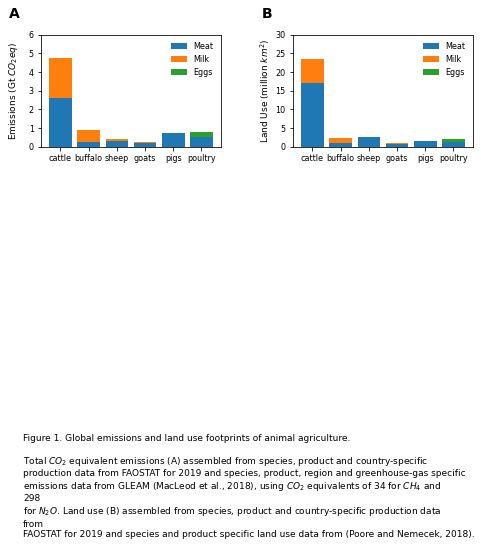

In [169]:
fignum = 1
pdffile = "Figures/Figure%d.pdf" % fignum


with PdfPages(pdffile) as pdf:    

    #figh = 6.0
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 2.5
    panelh = panelw/1.61
    
    label_pos = -.115
    
    margin_top = 3.0
    
    panelx1 = 1.25
    panelx2 = 4.75
    panely = figh - margin_top - panelh
    
    ax = fig.add_axes([panelx1/figw,panely/figh,panelw/figw,panelh/figh])
    
    df = livestock_data.groupby('Category').sum()
    df['Emissions'] = df['Emissions|CO2|Livestock'] + 34/1000 * df['Emissions|CH4|Livestock'] + 298/1000 * df['Emissions|N2O|Livestock']
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat'].Emissions,
        df.loc['buffalo_meat'].Emissions,
        df.loc['sheep_meat'].Emissions,
        df.loc['goat_meat'].Emissions,
        df.loc['pig_meat'].Emissions,
        df.loc['chicken_meat'].Emissions + df.loc['duck_meat'].Emissions,
        ])

    plot_milk = np.array([
        df.loc['cow_milk'].Emissions,
        df.loc['buffalo_milk'].Emissions,
        df.loc['sheep_milk'].Emissions,
        df.loc['goat_milk'].Emissions,
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'].Emissions,
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Emissions (Gt $CO_{2}eq$)', fontsize=9)
    ax.set_ylim(0,6)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.15,"A",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    margin_between = 1
    
    #panelx = (figw - panelw)/2
    #panely -= panelh + margin_between
    
    ax = fig.add_axes([panelx2/figw,panely/figh,panelw/figw,panelh/figh])
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat']['Land Use'],
        df.loc['buffalo_meat']['Land Use'],
        df.loc['sheep_meat']['Land Use'],
        df.loc['goat_meat']['Land Use'],
        df.loc['pig_meat']['Land Use'],
        df.loc['chicken_meat']['Land Use'] + df.loc['duck_meat']['Land Use'], 
    ])

    plot_milk = np.array([
        df.loc['cow_milk']['Land Use'],
        df.loc['buffalo_milk']['Land Use'],
        df.loc['sheep_milk']['Land Use'],
        df.loc['goat_milk']['Land Use'],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs']['Land Use'],
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Land Use (million $km^2$)')
    ax.set_ylim(0,30)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.15,"B",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    
    flh = r"Figure %d. Global emissions and land use footprints of animal agriculture." % fignum
    
    flt = r'''Total $CO_2$ equivalent emissions (A) assembled from species, product and country-specific
production data from FAOSTAT for 2019 and species, product, region and greenhouse-gas
specific emissions data from GLEAM (MacLeod et al., 2018), using $CO_2$ equivalents of 34
for $CH_4$ and 298 for $N_{2}O$. Land use (B) assembled from species, product and country-specific
production data from FAOSTAT for 2019 and species and product specific land use data from
(Poore and Nemecek, 2018).
'''
    
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

### Figure 1-S1 - Animal Ag Emissions and Gas and Species

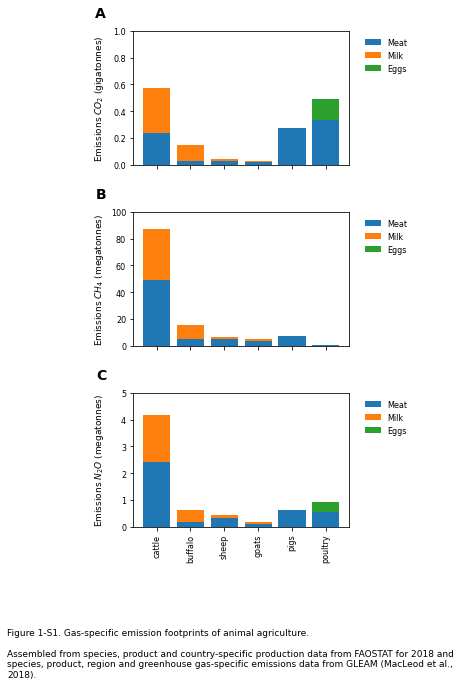

In [170]:
fignum = 1
supnum = 1
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = (figw - panelw)/2
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    df = livestock_data.groupby('Category').sum()
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    
    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CO2|Livestock" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pA1 = axA.bar(plot_species,plot_meat)
    pA2 = axA.bar(plot_species,plot_milk,bottom=plot_meat)
    pA3 = axA.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axA.set_ylabel(r"Emissions $CO_{2}$ (gigatonnes)")
    axA.set_ylim(0,1.0)
    axA.text(-.125,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks(np.arange(0,len(plot_species)))
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(-0.125,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CH4|Livestock" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pB1 = axB.bar(plot_species,plot_meat)
    pB2 = axB.bar(plot_species,plot_milk,bottom=plot_meat)
    pB3 = axB.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axB.set_ylabel(r"Emissions $CH_{4}$ (megatonnes)")
    axB.set_ylim(0,100)
    axB.text(-.125,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks(np.arange(0,len(plot_species)))
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(-0.125,0.5)
    axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left',frameon=False,bbox_to_anchor=(1.04,1.0))
   
    
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|N2O|Livestock" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    p1 = axC.bar(plot_species,plot_meat)
    p2 = axC.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = axC.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axC.set_ylabel(r"Emissions $N_{2}O$ (megatonnes)")
    axC.set_ylim(0,5)
    axC.text(-.125,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks(np.arange(0,len(plot_species)))
    axC.set_xticklabels(plot_species,rotation=90)
    axC.yaxis.set_label_coords(-0.125,0.5)
    axC.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))            
        
    
    flh = r"Figure %d-S%d. Gas-specific emission footprints of animal agriculture." % (fignum,supnum)
    
    flt = r'''Assembled from species, product and country-specific production data from FAOSTAT for
2018 and species, product, region and greenhouse gas-specific emissions data from
GLEAM (MacLeod et al., 2018).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

### Figure 2 - Comparing Baseline, Phaseout of Bovids and Phaseout of all Livestock 

Function creates different versions for different subsets of data

In [171]:
def Figure2(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 2
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - margin_top - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }
        
        gas_label = {
            'CO2' : r"$CO_2$",
            'CH4' : r"$CH_4$",
            'N2O' : r"$N_{2}O$"
        }
            
            
        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen2)],c='green',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen2)],c='green', linestyle='dashed')

            title = gas_label[gas] + " Emissions"
            ax[ai][0].set_title(title , fontsize=8)
            title = gas_label[gas] + " Atmospheric Concentration"
            ax[ai][1].set_title(title , fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,3):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,3):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)          


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2, linestyle='dashed'),
                Line2D([0],[0],color='green', lw=2),
            ]
    
            legend_labels = [
                'Business as Usual',
                scen2label,
                scenlabel,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(0,-.40), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
        #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

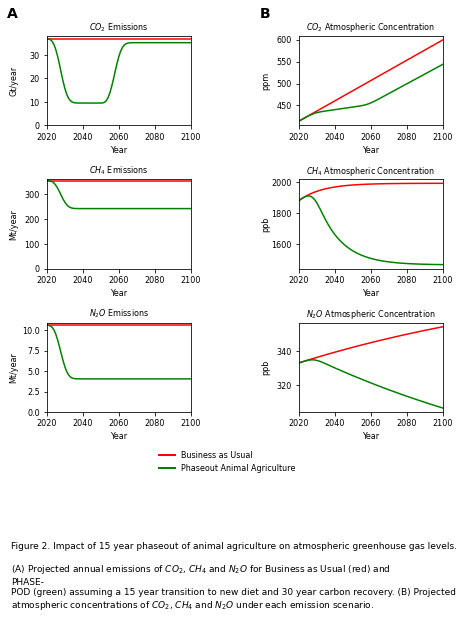

In [192]:
fignum = 2
plotname = "Figure%d" % fignum
plotlabel = r"Figure %d. Impact of 15 year phaseout of animal agriculture on atmospheric greenhouse gas levels." % fignum
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as Usual (red) and
PHASE-POD (green) assuming a 15 year transition to new diet and 30 year carbon recovery.
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission scenario.''' 

plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

#scen = "Elimination"
#scenlabel = "Plant Only Diet (Immediate Transition)"
scen = phaseout_scid
scenlabel = "Phaseout Animal Agriculture"


Figure2(plotname,plotlabel,plotcaption,scen,scenlabel)

## Figure 2-Supplements - Versions of Figure 2 for other scenarios

In [173]:
def EmLeRF_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures_Supplements/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 1
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - 1 - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2,3]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }

        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen2)],c='green',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen2)],c='green', linestyle='dashed')

            ax[ai][0].set_title("Emissions " + gas, fontsize=8)
            ax[ai][1].set_title("Atmospheric Concentration " + gas, fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        ax[3][1].plot(r['RF|BAU'],c='red')
        ax[3][1].plot(r['RF|%s' %scen],c='green')
        if scen2 != "":
            ax[3][1].plot(r['RF|%s' %scen2],c='green',linestyle='dashed')
        ax[3][1].set_title("Combined Global Warming Impact", fontsize=8)
        ax[3][1].yaxis.set_label_coords(label_pos,0.5)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[3][1].text(label_pos,1.2,"C",transform=ax[3][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,4):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,4):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)

        ax[3][0].set_visible(False)
        ax[3][1].set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)                


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2, linestyle='dashed'),
                Line2D([0],[0],color='green', lw=2),
            ]
    
            legend_labels = [
                'Business as Usual',
                scen2label,
                scenlabel,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(-.75,.5), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
        
        plt.close()
        #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

In [174]:
phaseout_scid

'PH15_CR30_RP100_BAU_CR_F'

In [175]:
plot_names = {
    'PH15_CR30_RP100_BAU_CR_F' : 'PHASE-POD (Default)',
    'PH30_CR30_RP100_BAU_CR_F' : '30yr Phaseout',
    'PH00_CR30_RP100_BAU_CR_F' : 'IMM-POD',
    'PH15_CR50_RP100_BAU_CR_F' : '50 Year Biomass Recovery',
    'PH15_CR70_RP100_BAU_CR_F' : '70 Year Biomass Recovery',
    'Net Zero|CO2' : 'Zero Non-ag CO2 by 2050',
    'PH15_CR30_RP075_BAU_CR_F' : '75% Biomass Recovery',
    'PH15_CR30_RP050_BAU_CR_F' : '50% Biomass Recovery',
    'PH15_CR30_RP025_BAU_CR_F' : '25% Biomass Recovery',
    'PH15_CR30_RP000_BAU_CR_F' : '0% Biomass Recovery',
    'Phaseout|Hayek High' : 'Hayak High Biomass Potential',
    'Phaseout|Hayek Low' : 'Hayak Low Biomass Potential',
    'PH15_CR30_RP100_BAU_CR_X' : 'Xu et al. Animal Ag Emissions',
    'PH15_CR30_RP100_BAU_PR_F' : 'Xu et al. Replacement Diet',
}


plot_scenarios = [
    ['PH15_CR30_RP100_BAU_CR_F','PH00_CR30_RP100_BAU_CR_F','15yr Phaseout vs. Elimination'],
    ['PH15_CR30_RP100_BAU_CR_F','PH30_CR30_RP100_BAU_CR_F','15yr vs. 30yr Phaseout'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR50_RP100_BAU_CR_F','30yr vs. 50yr Biomass Recovery'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR70_RP100_BAU_CR_F','30yr vs. 70yr Biomass Recovery'],
    ['PH15_CR30_RP100_BAU_CR_F','Phaseout|Hayek Low','Hayek Median vs. Low Recovery Potential'],
    ['PH15_CR30_RP100_BAU_CR_F','Phaseout|Hayek High','Hayek Median vs. High Recovery Potential'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR30_RP075_BAU_CR_F','100% vs. 75% Biomass Recovery'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR30_RP050_BAU_CR_F','100% vs. 50% Biomass Recovery'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR30_RP025_BAU_CR_F','100% vs. 25% Biomass Recovery'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR30_RP000_BAU_CR_F','100% vs. 0% Biomass Recovery'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR30_RP100_BAU_CR_X','FAO vs. Xu Emissions'],
    ['PH15_CR30_RP100_BAU_CR_F','PH15_CR30_RP100_BAU_PR_F','FAO vs. Xu Replacement Diet'],
    ['PH15_CR30_RP100_BAU_CR_F','Net Zero|CO2','15yr Phaseout vs. Net Zero CO2'],
    
]

for group in groups:
    scid = 'Phaseout|%s' % group
    plot_names[scid] = "Phaseout %s" % group.replace("_"," ")
    plot_scenarios.append(['PH15_CR30_RP100_BAU_CR_F', scid,'Phaseout of %s' % group.replace("_"," ").title()],)

plot_scenarios
    
    
    
fignum = 2

for i, plot_scenario in enumerate(plot_scenarios):
    supnum = (i+1)
    plotname = "Figure%d-S%d" % (fignum,supnum)
    plotlabel = r"Figure %d-S%d. %s." % (fignum,supnum,plot_scenario[2])
    plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for each scenarios.
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission
scenario. (C) Radiative Forcing (RF) inferred from atmospheric concentrations in
(B) by formula of (Myhre et al., 1998; Ramaswamy et al., 2001) as modified in
MAGICC6 (Meinshausen et al., 2011). Only differences between PHASE-POD default assumptions
(15yr phaseout, 30yr carbon recovery, 100% carbon recovery, BAU non-agriculture emissions, FAO crop
replacement, and FAO animal ag emissions) are given.'''

    plotcaption = plotcaption.replace("CO2",r"$CO_2$")
    plotcaption = plotcaption.replace("CH4",r"$CH_4$")
    plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

    scen = plot_scenario[0]
    scenlabel = plot_names[plot_scenario[0]]
    
    if plot_scenario[1] != "":    
        scen2 = plot_scenario[1]
        scen2label = plot_names[plot_scenario[1]]
        EmLeRF_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)
    else:
        EmLeRF_plot(plotname,plotlabel,plotcaption,scen,scenlabel)





    


### Figure 3 - Radiative Forcing of BAU vs Phaseout

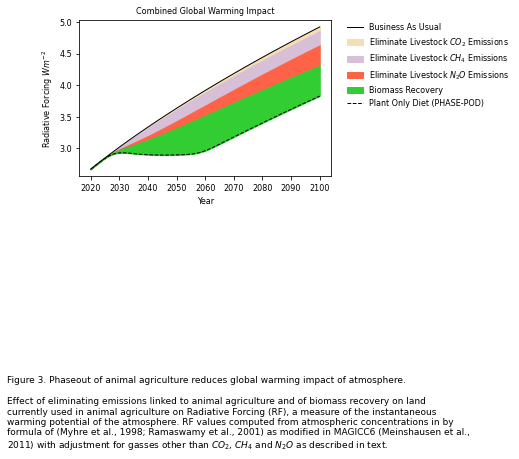

In [195]:
fignum = 3
pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    df = scenarios.loc[2020:2100]
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 4

    panelx = 2
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    

    l1 = ax.plot(df.index,df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    fb1 = ax.fill_between(df.index,df['RFC|BAU'],df['RFC|Phaseout_Breakdown_CO2'],label=r'Eliminate Livestock $CO_2$ Emissions',color='wheat')
    fb2 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2'],df['RFC|Phaseout_Breakdown_CO2_CH4'],label=r'Eliminate Livestock $CH_4$ Emissions',color='thistle')
    fb3 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4'],df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],label=r'Eliminate Livestock $N_{2}O$ Emissions',color='tomato')
    fb4 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],df['RFC|%s' % phaseout_scid],label='Biomass Recovery',color='limegreen')
    l2 = ax.plot(df.index,df['RFC|%s' % phaseout_scid],color='black',linestyle='dashed',label='Plant Only Diet (PHASE-POD)',linewidth=1)
    df = calib_scenarios.loc[2020:2100]
    #ax.plot(df['RFC|BAU_m28GT'],c='gray',linestyle='dashed',label=r'28Gt/year $CO_2$ reduction from BAU')
    ax.set_title("Combined Global Warming Impact", fontsize=8)

    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    ax.set_xlabel("Year",fontsize=8)
    #ax.legend()
    
    ax.legend([l1[0],fb1,fb2,fb3,fb4,l2[0]],['Business As Usual',r'Eliminate Livestock $CO_2$ Emissions',
                                            r'Eliminate Livestock $CH_4$ Emissions',r'Eliminate Livestock $N_{2}O$ Emissions',
                                            'Biomass Recovery','Plant Only Diet (PHASE-POD)'],bbox_to_anchor=(1.05,1.0), borderaxespad=0, frameon=False)
    
    flh = r"Figure 3. Phaseout of animal agriculture reduces global warming impact of atmosphere."
    
    flt = r'''Effect of eliminating emissions linked to animal agriculture and of biomass recovery on land currently used
in animal agriculture on Radiative Forcing (RF), a measure of the instantaneous warming potential of the atmosphere.
RF values computed from atmospheric concentrations in by formula of (Myhre et al., 1998;
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011) with adjustment for gasses other than
CO2, CH4 and N2O as described in text.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

## Figure 3-S1

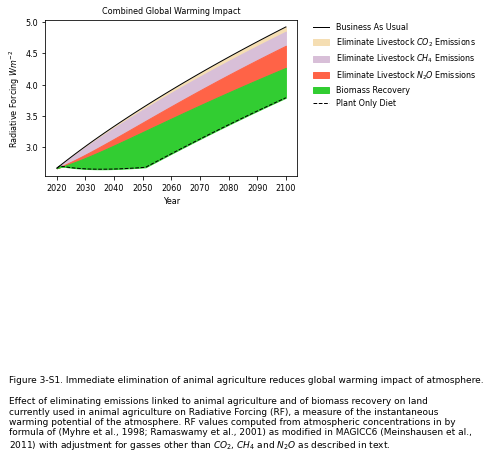

In [177]:
fignum = 3
supnum = 1
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    
    df = scenarios.loc[2020:2100]
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 4

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    

    l1 = ax.plot(df.index,df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    fb1 = ax.fill_between(df.index,df['RFC|BAU'],df['RFC|Elimination_Breakdown_CO2'],label=r'Eliminate Livestock $CO_2$ Emissions',color='wheat')
    fb2 =ax.fill_between(df.index,df['RFC|Elimination_Breakdown_CO2'],df['RFC|Elimination_Breakdown_CO2_CH4'],label=r'Eliminate Livestock $CH_4$ Emissions',color='thistle')
    fb3 =ax.fill_between(df.index,df['RFC|Elimination_Breakdown_CO2_CH4'],df['RFC|Elimination_Breakdown_CO2_CH4_N2O'],label=r'Eliminate Livestock $N_{2}O$ Emissions',color='tomato')
    fb4 =ax.fill_between(df.index,df['RFC|Elimination_Breakdown_CO2_CH4_N2O'],df['RFC|%s' % elimination_scid],label='Biomass Recovery',color='limegreen')
    l2 = ax.plot(df.index,df['RFC|%s' % elimination_scid],color='black',linestyle='dashed',label='Plant Only Diet',linewidth=1)
    df = calib_scenarios.loc[2020:2100]
    #ax.plot(df['RFC|BAU_m28GT'],c='gray',linestyle='dashed',label=r'28Gt/year $CO_2$ reduction from BAU')
    ax.set_title("Combined Global Warming Impact", fontsize=8)

    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    ax.set_xlabel("Year",fontsize=8)
    #ax.legend()
    
    ax.legend([l1[0],fb1,fb2,fb3,fb4,l2[0]],['Business As Usual',r'Eliminate Livestock $CO_2$ Emissions',r'Eliminate Livestock $CH_4$ Emissions',r'Eliminate Livestock $N_{2}O$ Emissions',
                                      'Biomass Recovery','Plant Only Diet'],bbox_to_anchor=(1.05,1.0), borderaxespad=0, frameon=False)
    
    flh = r"Figure %d-S%d. Immediate elimination of animal agriculture reduces global warming impact of atmosphere." % (fignum,supnum)
    
    flt = r'''Effect of eliminating emissions linked to animal agriculture and of biomass recovery on land currently used
in animal agriculture on Radiative Forcing (RF), a measure of the instantaneous warming potential of the atmosphere.
RF values computed from atmospheric concentrations in by formula of (Myhre et al., 1998;
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011) with adjustment for gasses other than
CO2, CH4 and N2O as described in text.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

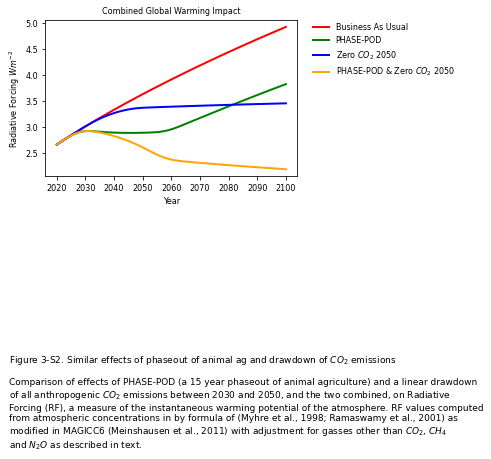

In [208]:
fignum = 3
supnum = 2
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    
    df = scenarios.loc[2020:2100]
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 4

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    

    l1 = ax.plot(df.index,df['RFC|BAU'],color='red',linewidth=2)
    l2 = ax.plot(df.index,df['RFC|%s' % phaseout_scid],color='green',linewidth=2)
    l3 = ax.plot(df.index,df['RFC|Net Zero|CO2'],color='blue',linewidth=2)
    l4 = ax.plot(df.index,df['RFC|%s' % phaseout_nz_scid],color='orange',linewidth=2)
    
    #ax.plot(df['RFC|BAU_m28GT'],c='gray',linestyle='dashed',label=r'28Gt/year $CO_2$ reduction from BAU')
    ax.set_title("Combined Global Warming Impact", fontsize=8)

    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    ax.set_xlabel("Year",fontsize=8)

    ax.legend([l1[0],l2[0],l3[0],l4[0]],['Business As Usual','PHASE-POD','Zero $CO_2$ 2050',r'PHASE-POD & Zero $CO_2$ 2050'],
              bbox_to_anchor=(1.05,1.0), borderaxespad=0, frameon=False)
    
    flh = r"Figure %d-S%d. Similar effects of phaseout of animal ag and drawdown of $CO_2$ emissions" % (fignum,supnum)
    
    flt = r'''Comparison of effects of PHASE-POD (a 15 year phaseout of animal agriculture) and a linear drawdown of all
anthropogenic CO2 emissions between 2030 and 2050, and the two combined,
on Radiative Forcing (RF), a measure of the instantaneous warming potential of the atmosphere.
RF values computed from atmospheric concentrations in by formula of (Myhre et al., 1998;
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011) with adjustment for gasses other than
CO2, CH4 and N2O as described in text.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

### Figure 4 - Carbon Opportunity for Eliminating Animal Ag

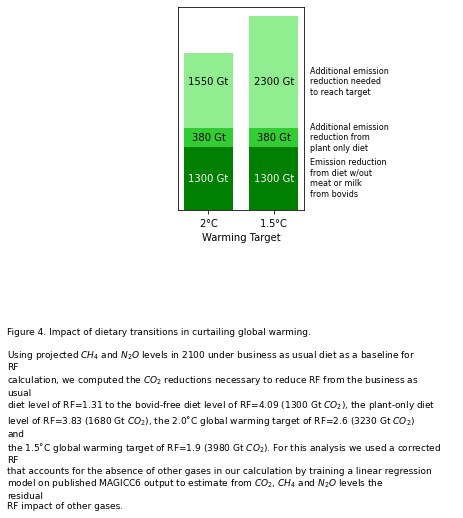

In [199]:
proj_end = scenarios.loc[2100]
fignum = 4

pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11

    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

   
    panelw = 1.75
    panelh = panelw * 1.61
    
    margin_top = 3

    panelx = (figw-panelw) / 2
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])


    # Data from Figure 3-S1 below
    
    labels = [r'2$\degree$C','1.5$\degree$C']
    
    ec = -elcoc.loc[phaseout_scid]['ELCOC']
    plant = np.array([ec,ec])
    ec = -elcoc.loc['Phaseout|bovids']['ELCOC']
    nobo = np.array([ec,ec])
    ec1 = -elcoc.loc['RF2.6']['ELCOC']
    ec2 = -elcoc.loc['RF1.9']['ELCOC']
    rftarget = np.array([ec1,ec2])
    width=.75
    
    l1 = ax.bar(labels,1000 * rftarget,width=width,color='lightgreen',label="Additional Emission Reductions Required to Reach Warming Target")
    l2 = ax.bar(labels,1000 * plant,width=width,color='limegreen',label='Additional Emission Reductions From Plant Only Diet')
    l3 = ax.bar(labels,1000 * nobo,width=width,color='green',label='Emission Reductions From No Bovid Diet')
    
    #ax.set_ylabel(r"$CO_{2}$ Emissions Reductions Gt",fontsize=10)
    
    ax.set_xticks(np.arange(0,len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    #ax.legend(bbox_to_anchor=(1,1.25), borderaxespad=0,fontsize=9,frameon=False)
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    ax.yaxis.set_label_coords(-1.5 * .075,0.5)
    ax.set_xlabel("Warming Target",fontsize=10)
    ax.set_yticklabels([])
    ax.set_yticks([])
    

# Add the patch to the Axes

    flh = "Figure %d. Impact of dietary transitions in curtailing global warming." % fignum
    
    flt = r'''Using projected CH4 and N2O levels in 2100 under business as usual diet
as a baseline for RF calculation, we computed the CO2 reductions necessary
to reduce RF from the business as usual diet level of RF=%.2f to the bovid-free diet
level of RF=%.2f (%d Gt CO2), the plant-only diet level of RF=%.2f (%d Gt CO2),
the 2.0˚C global warming target of RF=2.6 (%d Gt CO2) and the 1.5˚C global warming
target of RF=1.9 (%d Gt CO2). For this analysis we used a corrected RF that accounts
for the absence of other gases in our calculation by training a linear
regression model on published MAGICC6 output to estimate from CO2, CH4 and N2O
levels the residual RF impact of other gases. ''' % (
        elcoc.loc['Baseline']['RF'],
        elcoc.loc['Phaseout|bovids']['RF'],
        -elcoc.loc['Phaseout|bovids']['ELCOC'] * 1000,
        elcoc.loc[phaseout_scid]['RF'],
        -elcoc.loc[phaseout_scid]['ELCOC'] * 1000,
        -elcoc.loc['RF2.6']['ELCOC'] * 1000,
        -elcoc.loc['RF1.9']['ELCOC'] * 1000,
    )
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    
    #annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=40)

    #plt.figtext(1/figw, (figh - 1)/figh, annot_txt, horizontalalignment='left', verticalalignment='top', fontsize=cap_fontsize, multialignment='left', wrap="True")    
    
    v1 = -elcoc.loc['Phaseout|bovids']['ELCOC'] * 1000
    h1 = v1/2
    
    ax.text(1.55,h1,"Emission reduction\nfrom diet w/out\nmeat or milk\nfrom bovids",fontsize=8, verticalalignment='center')
    vlab = "%d Gt" % (v1)
    ax.text(0,h1,vlab,horizontalalignment='center',color='white',verticalalignment='center')
    ax.text(1,h1,vlab,horizontalalignment='center',color='white',verticalalignment='center')
    
    
    v2 = -elcoc.loc[phaseout_scid]['ELCOC'] * 1000
    h2 = v1 + 0.5 * (v2 - v1)
    
    ax.text(1.55,h2,"Additional emission\nreduction from\nplant only diet",fontsize=8, verticalalignment='center')
    vlab = "%d Gt" % (v2 - v1)
    ax.text(0,h2,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    ax.text(1,h2,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    
    
    v3 = -elcoc.loc['RF2.6']['ELCOC'] * 1000
    v4 = -elcoc.loc['RF1.9']['ELCOC'] * 1000
    
    h3 = v2 + 0.25 * (v3 - v2) + 0.25 * (v4 - v2)
    
    ax.text(1.55,h3,"Additional emission\nreduction needed\nto reach target",fontsize=8, verticalalignment='center')
    vlab = "%d Gt" % (v3 - v2)
    ax.text(0,h3,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    vlab = "%d Gt" % (v4 - v2)
    ax.text(1,h3,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)

### Figure 4-S1

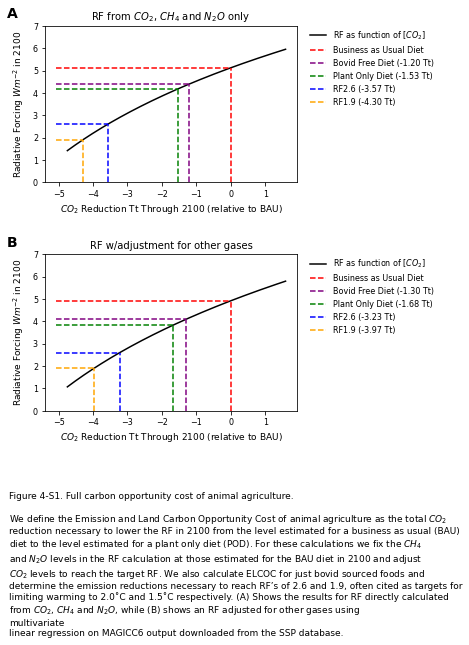

In [180]:
proj_end = scenarios.loc[2100]

fignum = 4
supnum = 1
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 1.5

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,500)

    CB = proj_end['Concentration|CO2|BAU']
    MB = proj_end['Concentration|CH4|BAU']
    NB = proj_end['Concentration|N2O|BAU']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    (x_C,x_M,x_N,x_R) = RF_MAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RF|BAU']))]
    ax.plot([px[0],xn],[proj_end['RF|BAU'],proj_end['RF|BAU']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RF|BAU']],c='red',linestyle='dashed')
    
    rft = proj_end['RF|Phaseout|bovids']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RF|%s' % phaseout_scid]
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)

    ax.text(-.15,1.05,"A",transform=ax.transAxes,fontsize=14,fontweight='bold')
    title = r"RF from $CO_2$, $CH_4$ and $N_{2}O$ only"
    ax.set_title(title)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)

    
    panely = figh - margin_top - panelh - 1.0 - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,1000)

    CB = proj_end['Concentration|CO2|BAU']
    MB = proj_end['Concentration|CH4|BAU']
    NB = proj_end['Concentration|N2O|BAU']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    x_R = RF_cMAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RFC|BAU']))]
    ax.plot([px[0],xn],[proj_end['RFC|BAU'],proj_end['RFC|BAU']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RFC|BAU']],c='red',linestyle='dashed')
    
    rft = proj_end['RFC|Phaseout|bovids']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RFC|%s' % phaseout_scid]
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)
    
    ax.text(-.15,1.05,"B",transform=ax.transAxes,fontsize=14,fontweight='bold')
    ax.set_title("RF w/adjustment for other gases")
    
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    
    flh = r"Figure %d-S%d. Full carbon opportunity cost of animal agriculture." % (fignum,supnum)
    
    flt = r'''We define the Emission and Land Carbon Opportunity Cost of animal agriculture as
the total CO2 reduction necessary to lower the RF in 2100 from the level estimated
for a business as usual (BAU) diet to the level estimated for a plant only diet
(POD). For these calculations we fix the CH4 and N2O levels in the RF calculation
at those estimated for the BAU diet in 2100 and adjust CO2 levels to reach the target RF.
We also calculate ELCOC for just bovid sourced foods and determine the emission
reductions necessary to reach RF’s of 2.6 and 1.9, often cited as targets for limiting warming
to 2.0˚C and 1.5˚C respectively. (A) Shows the results for RF directly calculated from
CO2, CH4 and N2O, while (B) shows an RF adjusted for other gases using multivariate
linear regression on MAGICC6 output downloaded from the SSP database.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

###  Figure 5: ACO2EQ 

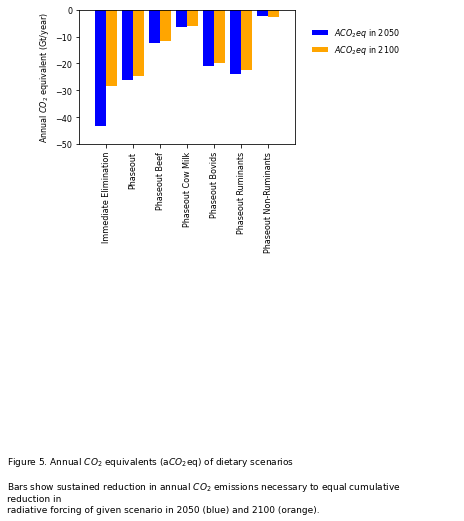

In [200]:
fignum = 5

pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf: 

    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))
    
    
    panelw = 3
    panelh = panelw/1.61
    
    margin_top = 3
    
    panelx = 2.0
    panely = figh - margin_top - panelh
    
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    plot_scenarios = [elimination_scid,phaseout_scid,'Phaseout|cattle_meat','Phaseout|cow_milk','Phaseout|bovids','Phaseout|ruminants','Phaseout|non-ruminants']
    plot_labels = ['Immediate Elimination','Phaseout','Phaseout Beef','Phaseout Cow Milk','Phaseout Bovids','Phaseout Ruminants','Phaseout Non-Ruminants']

    x = np.arange(0,len(plot_scenarios))

    r = scenarios.loc[2050]
    y = [-r['ACO2EQ|%s'% s] for s in plot_scenarios]
    ax.bar(x-.2, y,.4,color='blue',label=r"$ACO_{2}eq$ in 2050")

    r = scenarios.loc[2100]
    y = [-r['ACO2EQ|%s'% s] for s in plot_scenarios]
    ax.bar(x+.2, y,.4,color='orange',label=r"$ACO_{2}eq$ in 2100")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels,rotation=90,fontsize=8)
    ax.set_ylabel(r"Annual $CO_2$ equivalent (Gt/year)",fontsize = 8)
    

    #ax.plot([-1,len(plot_scenarios)],[0,0],color='red',linestyle='dashed',linewidth=.1,label="Current Annual Emissions")
    ax.set_xlim(-1,len(plot_scenarios))
    ax.set_ylim(-50,0)
    
    plt.legend(bbox_to_anchor=(1.5,0.9), borderaxespad=0, frameon=False)
    
    flh = "Figure %d. Annual $CO_2$ equivalents (a$CO_2$eq) of dietary scenarios" % fignum
    
    flt = r'''Bars show sustained reduction in annual CO2 emissions necessary
to equal cumulative reduction in radiative forcing of given scenario in 2050 (blue)
and 2100 (orange).'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")  
    
        
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)

### Figure 5-S1 - Details of Calibration for ACO2eq

In [182]:
def EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures_Supplements/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

        panelw = 2
        panelh = panelw/1.75

        margin_top = 1
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - 1 - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2,3]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }

        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        rc = calib_scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(rc['Emissions|%s|%s' % (gas,scen2)],c='blue',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(rc['Concentration|%s|%s' % (gas,scen2)],c='blue', linestyle='dashed')

            ax[ai][0].set_title("Emissions " + gas, fontsize=8)
            ax[ai][1].set_title("Atmospheric Concentration " + gas, fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)


        ax[3][0].plot(r['RF|BAU'] ,c='red')
        ax[3][0].plot(r['RF|%s' %scen] ,c='green')
        if scen2 != "":
            ax[3][0].plot(rc['RF|%s' %scen2],c='blue',linestyle='dashed')
        ax[3][0].set_title("", fontsize=8)
        ax[3][0].yaxis.set_label_coords(label_pos,0.5)
        
            
        ax[3][1].plot(r['CRFD|BAU'] * (5.1E+14/1E+15),c='red')
        ax[3][1].plot(r['CRFD|%s' %scen] * (5.1E+14/1E+15),c='green')
        if scen2 != "":
            ax[3][1].plot(rc['CRFD|%s' %scen2] * (5.1E+14/1E+15),c='blue',linestyle='dashed')
        ax[3][1].set_title("Reduced Atmospheric Heating", fontsize=8)
        ax[3][1].yaxis.set_label_coords(label_pos,0.5)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[3][0].text(label_pos,1.2,"C",transform=ax[3][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[3][1].text(label_pos,1.2,"D",transform=ax[3][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,4):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,4):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)

        ax[3][0].set_ylabel("Radiative Forcing ($Wm^{-2}$)",fontsize=8)      
        ax[3][1].set_ylabel("Cumulative RF Reduction\n(Petawatt-years)",fontsize=8)                


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2),
                Line2D([0],[0],color='blue', lw=2, linestyle='dashed'),
            ]
    
            legend_labels = [
                'Business as Usual',
                scenlabel,
                scen2label,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(0,-.4), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
    

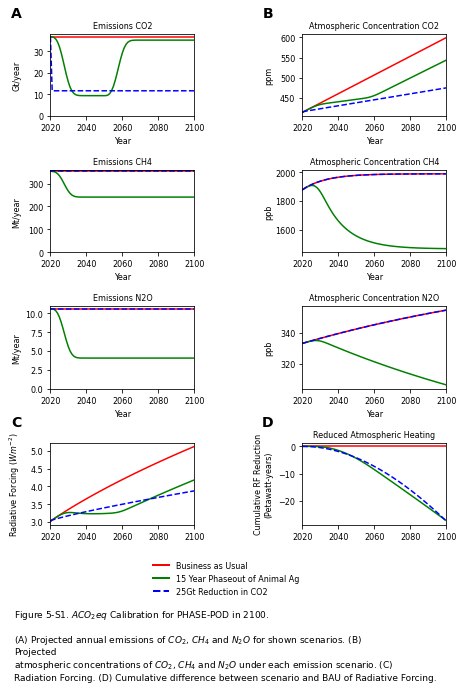

In [183]:
ACO2eq = np.round(scenarios.loc[2100]['ACO2EQ|%s' % phaseout_scid],0)

plot_names = {
    phaseout_scid : '15 Year Phaseout of Animal Ag',
    elimination_scid : 'Immediate Elimination of Animal Ag',
    'BAU_m%02dGT' % ACO2eq : '%02dGt Reduction in CO2' % ACO2eq
    
}


plot_scenarios = [
    [phaseout_scid,'BAU_m%02dGT' % ACO2eq ,r"$ACO_{2}eq$ Calibration for PHASE-POD in 2100"],
]


fignum = 5
supnum = 1

for i, plot_scenario in enumerate(plot_scenarios):
    plotname = "Figure%d-S%d" % (fignum,supnum)
    plotlabel = r"Figure %d-S%d. %s." % (fignum,supnum,plot_scenario[2])
    plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for shown scenarios.
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission
scenario. (C) Radiation Forcing. (D) Cumulative difference between scenario and BAU of Radiative Forcing.'''

    plotcaption = plotcaption.replace("CO2",r"$CO_2$")
    plotcaption = plotcaption.replace("CH4",r"$CH_4$")
    plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

    scen = plot_scenario[0]
    scenlabel = plot_names[plot_scenario[0]]
    
    if plot_scenario[1] != "":    
        scen2 = plot_scenario[1]
        scen2label = plot_names[plot_scenario[1]]
        EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)
    else:
        EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel)




    

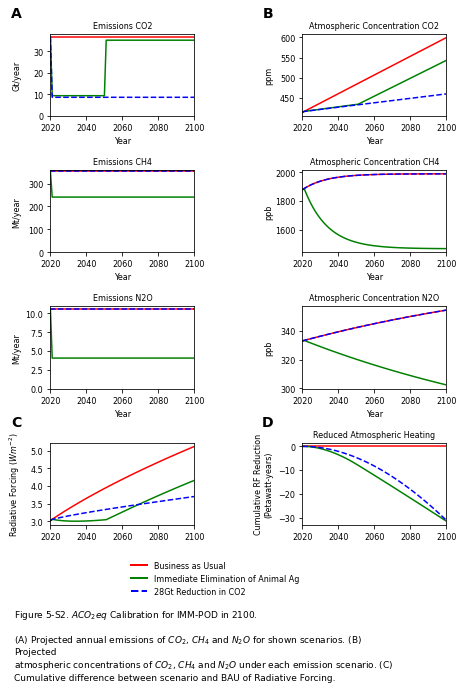

In [184]:
ACO2eq = scenarios.loc[2100]['ACO2EQ|%s' % elimination_scid]

plot_names = {
    phaseout_scid : '15 Year Phaseout of Animal Ag',
    elimination_scid : 'Immediate Elimination of Animal Ag',
    'BAU_m%02dGT' % ACO2eq : '%02dGt Reduction in CO2' % ACO2eq,
}


plot_scenarios = [
    [elimination_scid,'BAU_m%02dGT' % ACO2eq ,r"$ACO_{2}eq$ Calibration for IMM-POD in 2100."],
]


fignum = 5
supnum = 2

for i, plot_scenario in enumerate(plot_scenarios):
    plotname = "Figure%d-S%d" % (fignum,supnum)
    plotlabel = r"Figure %d-S%d. %s" % (fignum,supnum,plot_scenario[2])
    plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for shown scenarios.
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission
scenario. (C) Cumulative difference between scenario and BAU of Radiative Forcing.'''

    plotcaption = plotcaption.replace("CO2",r"$CO_2$")
    plotcaption = plotcaption.replace("CH4",r"$CH_4$")
    plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

    scen = plot_scenario[0]
    scenlabel = plot_names[plot_scenario[0]]
    
    if plot_scenario[1] != "":    
        scen2 = plot_scenario[1]
        scen2label = plot_names[plot_scenario[1]]
        EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)
    else:
        EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel)




    

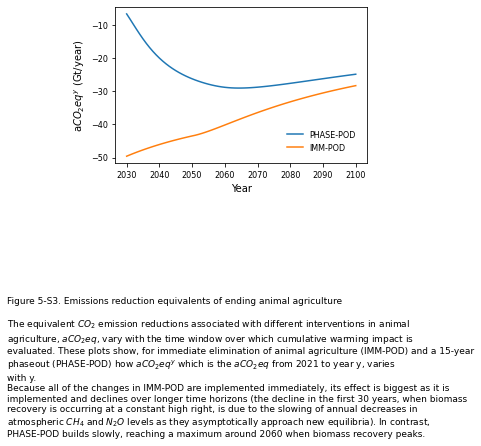

In [185]:
fignum = 5
supnum = 3
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    
    df = scenarios.loc[2030:2100]
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 4

    panelx = 2.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    l1 = ax.plot(-df['ACO2EQ|%s' % phaseout_scid])
    l2 = ax.plot(-df['ACO2EQ|%s' % elimination_scid])

    #ax.set_title("", fontsize=10)

    ax.set_ylabel(r"a$CO_{2}eq^y$ (Gt/year)",fontsize=10)     
    ax.set_xlabel("Year",fontsize=10)     
    
    #ax.legend()
    
    ax.legend([l1[0],l2[0]],['PHASE-POD','IMM-POD'],loc='lower right', borderaxespad=1, frameon=False)
    
    flh = r"Figure %d-S%d. Emissions reduction equivalents of ending animal agriculture" % (fignum,supnum)
    
    flt = r'''The equivalent CO2 emission reductions associated with different interventions in animal agriculture, $aCO_{2}eq$,
vary with the time window over which cumulative warming impact is evaluated. These plots show, for immediate elimination of animal
agriculture (IMM-POD) and a 15-year phaseout (PHASE-POD) how $aCO_{2}eq^y$ which is the $aCO_{2}eq$ from 2021 to year y, varies with y.
Because all of the changes in IMM-POD are implemented immediately, its effect is biggest as it is implemented and declines over longer
time horizons (the decline in the first 30 years, when biomass recovery is occurring at a constant high right, is due to the slowing of
annual decreases in atmospheric CH4 and N2O levels as they asymptotically approach new equilibria). In contrast, PHASE-POD builds slowly,
reaching a maximum around 2060 when biomass recovery peaks.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

### Figure 6 - ACO2EQ for Product, Protein 

<ipython-input-202-41b8b2faf664>:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  axBt.set_yticklabels([str(int(-x)) for x in axBt.get_yticks()])
<ipython-input-202-41b8b2faf664>:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  axCt.set_yticklabels([str(int(-x)) for x in axCt.get_yticks()])


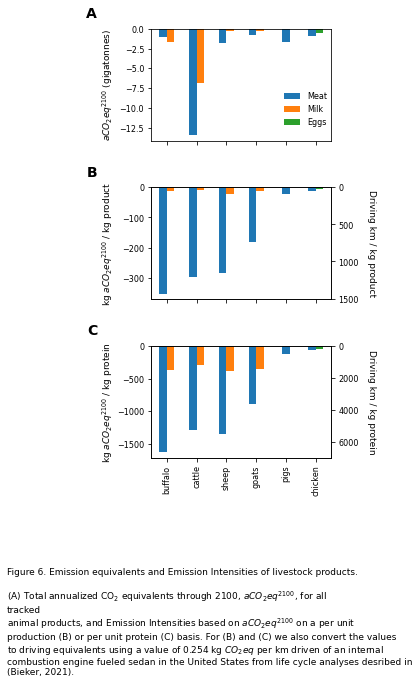

In [202]:
fignum = 6
pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 2.5
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = 3.0
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    bar_offset = .25
    bar_width = .25
    legend_x = .70
    label_x_offset = -.2
    
    bar_off_meat = np.array([-bar_width/2,-bar_width/2,-bar_width/2,-bar_width/2,0,-bar_width/2])
    bar_off_milk = np.array([bar_width/2,bar_width/2,bar_width/2,bar_width/2,0,0])
    bar_off_eggs = np.array([0,0,0,0,0,bar_width/2])
    
    r = scenarios.loc[2100]
    plot_species = ['buffalo','cattle','sheep','goats','pigs','chicken']

    x_labels = ['buffalo','cattle','sheep','goats','pigs','chicken']
    x_coords = np.array([1,2,3,4,5,6])

    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])

    meat_data = [
        r['ACO2EQ|Elimination|buffalo_meat'],
        r['ACO2EQ|Elimination|cattle_meat'],
        r['ACO2EQ|Elimination|sheep_meat'],
        r['ACO2EQ|Elimination|goat_meat'],
        r['ACO2EQ|Elimination|pig_meat'],
        r['ACO2EQ|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['ACO2EQ|Elimination|buffalo_milk'],
        r['ACO2EQ|Elimination|cow_milk'],
        r['ACO2EQ|Elimination|sheep_milk'],
        r['ACO2EQ|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['ACO2EQ|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
        
    meat_data = - meat_data
    milk_data = - milk_data
    egg_data = - egg_data
    
    pA1 = axA.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pA2 = axA.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pA3 = axA.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axA.set_ylabel(r'$aCO_2eq^{2100}$ (gigatonnes)')
    axA.text(label_x_offset-.1,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks([1,2,3,4,5,6])
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(label_x_offset,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,0.5))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perunit|Elimination|buffalo_meat'],
        r['EI_perunit|Elimination|cattle_meat'],
        r['EI_perunit|Elimination|sheep_meat'],
        r['EI_perunit|Elimination|goat_meat'],
        r['EI_perunit|Elimination|pig_meat'],
        r['EI_perunit|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perunit|Elimination|buffalo_milk'],
        r['EI_perunit|Elimination|cow_milk'],
        r['EI_perunit|Elimination|sheep_milk'],
        r['EI_perunit|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perunit|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
            
    meat_data = - meat_data
    milk_data = - milk_data
    egg_data = - egg_data
    
    pB1 = axB.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pB2 = axB.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pB3 = axB.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axB.set_ylabel(r'kg $aCO_2eq^{2100}$ / kg product')
    #axA.set_ylim(0,1.0)
    axB.text(label_x_offset-.1,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks([1,2,3,4,5,6])
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(label_x_offset,0.5,transform=axB.transAxes)
    #axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axBt = axB.twinx()
    ymin = axB.get_ylim()[0]
    ymax = axB.get_ylim()[1]
    axBt.set_ylim(ymin*km_per_kgco2,ymax*km_per_kgco2)
    axBt.set_yticklabels([str(int(-x)) for x in axBt.get_yticks()])
    axBt.set_ylabel(r'Driving km / kg product',rotation=-90)
    axBt.yaxis.set_label_coords(1.25,0.5,transform=axBt.transAxes)
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perprotein|Elimination|buffalo_meat'],
        r['EI_perprotein|Elimination|cattle_meat'],
        r['EI_perprotein|Elimination|sheep_meat'],
        r['EI_perprotein|Elimination|goat_meat'],
        r['EI_perprotein|Elimination|pig_meat'],
        r['EI_perprotein|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perprotein|Elimination|buffalo_milk'],
        r['EI_perprotein|Elimination|cow_milk'],
        r['EI_perprotein|Elimination|sheep_milk'],
        r['EI_perprotein|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perprotein|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)    
    
            
    meat_data = - meat_data
    milk_data = - milk_data
    egg_data = - egg_data
    
    
    pC1 = axC.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pC2 = axC.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pC3 = axC.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axC.set_ylabel(r'kg $aCO_2eq^{2100}$ / kg protein')
    #axA.set_ylim(0,1.0)
    axC.text(label_x_offset-.1,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks([1,2,3,4,5,6])
    axC.set_xticklabels([])
    axC.yaxis.set_label_coords(label_x_offset,0.5,transform=axC.transAxes)
    #axC.legend((pC1[0], pC2[0], pC3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axCt = axC.twinx()
    ymin = axC.get_ylim()[0]
    ymax = axC.get_ylim()[1]
    
    axCt.set_ylim(ymin * km_per_kgco2,ymax *km_per_kgco2)
    axCt.set_yticklabels([str(int(-x)) for x in axCt.get_yticks()])
    axCt.set_ylabel(r'Driving km / kg protein',rotation=-90)
    axCt.yaxis.set_label_coords(1.25,0.5,transform=axCt.transAxes)
    panely -= panelh + panel_margin        
    axC.set_xticklabels(x_labels,rotation=90)
    
    flh = r"Figure %d. Emission equivalents and Emission Intensities of livestock products." % fignum
    
    flt = r'''(A) Total annualized CO$_2$ equivalents through 2100, $aCO_2eq^{2100}$,
for all tracked animal products, and Emission Intensities based on $aCO_2eq^{2100}$ on a per unit production (B) or per unit protein (C) basis.
For (B) and (C) we also convert the values to driving equivalents using a value of 0.254 kg $CO_2eq$
per km driven of an internal combustion engine fueled sedan in the United States from life cycle analyses
desribed in (Bieker, 2021).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=90)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

Figures_Supplements/Figure6-S1.pdf


<ipython-input-187-8a69da2e8145>:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  axBt.set_yticklabels([str(int(-x)) for x in axBt.get_yticks()])
<ipython-input-187-8a69da2e8145>:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  axCt.set_yticklabels([str(int(-x)) for x in axCt.get_yticks()])


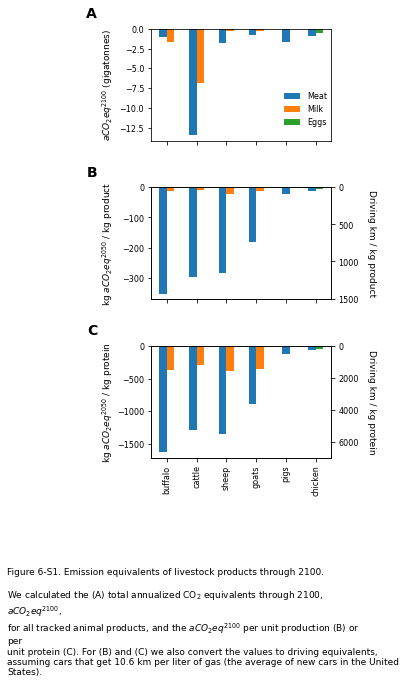

In [187]:
fignum = 6
supnum = 1
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

print (pdffile)
with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 2.5
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = 3.0
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    bar_offset = .25
    bar_width = .25
    legend_x = .70
    label_x_offset = -.2
    
    bar_off_meat = np.array([-bar_width/2,-bar_width/2,-bar_width/2,-bar_width/2,0,-bar_width/2])
    bar_off_milk = np.array([bar_width/2,bar_width/2,bar_width/2,bar_width/2,0,0])
    bar_off_eggs = np.array([0,0,0,0,0,bar_width/2])
    
    r = scenarios.loc[2100]
    plot_species = ['buffalo','cattle','sheep','goats','pigs','chicken']

    x_labels = ['buffalo','cattle','sheep','goats','pigs','chicken']
    x_coords = np.array([1,2,3,4,5,6])

    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])

    meat_data = [
        r['ACO2EQ|Elimination|buffalo_meat'],
        r['ACO2EQ|Elimination|cattle_meat'],
        r['ACO2EQ|Elimination|sheep_meat'],
        r['ACO2EQ|Elimination|goat_meat'],
        r['ACO2EQ|Elimination|pig_meat'],
        r['ACO2EQ|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['ACO2EQ|Elimination|buffalo_milk'],
        r['ACO2EQ|Elimination|cow_milk'],
        r['ACO2EQ|Elimination|sheep_milk'],
        r['ACO2EQ|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['ACO2EQ|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
        
    meat_data = - meat_data
    milk_data = - milk_data
    egg_data = - egg_data
    
    pA1 = axA.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pA2 = axA.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pA3 = axA.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axA.set_ylabel(r'$aCO_2eq^{2100}$ (gigatonnes)')
    axA.text(label_x_offset-.1,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks([1,2,3,4,5,6])
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(label_x_offset,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,0.5))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perunit|Elimination|buffalo_meat'],
        r['EI_perunit|Elimination|cattle_meat'],
        r['EI_perunit|Elimination|sheep_meat'],
        r['EI_perunit|Elimination|goat_meat'],
        r['EI_perunit|Elimination|pig_meat'],
        r['EI_perunit|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perunit|Elimination|buffalo_milk'],
        r['EI_perunit|Elimination|cow_milk'],
        r['EI_perunit|Elimination|sheep_milk'],
        r['EI_perunit|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perunit|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
            
    meat_data = - meat_data
    milk_data = - milk_data
    egg_data = - egg_data
    
    pB1 = axB.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pB2 = axB.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pB3 = axB.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axB.set_ylabel(r'kg $aCO_2eq^{2050}$ / kg product')
    #axA.set_ylim(0,1.0)
    axB.text(label_x_offset-.1,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks([1,2,3,4,5,6])
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(label_x_offset,0.5,transform=axB.transAxes)
    #axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axBt = axB.twinx()
    ymin = axB.get_ylim()[0]
    ymax = axB.get_ylim()[1]
    axBt.set_ylim(ymin*km_per_kgco2,ymax*km_per_kgco2)
    axBt.set_yticklabels([str(int(-x)) for x in axBt.get_yticks()])
    axBt.set_ylabel(r'Driving km / kg product',rotation=-90)
    axBt.yaxis.set_label_coords(1.25,0.5,transform=axBt.transAxes)
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perprotein|Elimination|buffalo_meat'],
        r['EI_perprotein|Elimination|cattle_meat'],
        r['EI_perprotein|Elimination|sheep_meat'],
        r['EI_perprotein|Elimination|goat_meat'],
        r['EI_perprotein|Elimination|pig_meat'],
        r['EI_perprotein|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perprotein|Elimination|buffalo_milk'],
        r['EI_perprotein|Elimination|cow_milk'],
        r['EI_perprotein|Elimination|sheep_milk'],
        r['EI_perprotein|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perprotein|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)    
    
            
    meat_data = - meat_data
    milk_data = - milk_data
    egg_data = - egg_data
    
    
    pC1 = axC.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pC2 = axC.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pC3 = axC.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axC.set_ylabel(r'kg $aCO_2eq^{2050}$ / kg protein')
    #axA.set_ylim(0,1.0)
    axC.text(label_x_offset-.1,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks([1,2,3,4,5,6])
    axC.set_xticklabels([])
    axC.yaxis.set_label_coords(label_x_offset,0.5,transform=axC.transAxes)
    #axC.legend((pC1[0], pC2[0], pC3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axCt = axC.twinx()
    ymin = axC.get_ylim()[0]
    ymax = axC.get_ylim()[1]
    
    axCt.set_ylim(ymin * km_per_kgco2,ymax *km_per_kgco2)
    axCt.set_yticklabels([str(int(-x)) for x in axCt.get_yticks()])
    axCt.set_ylabel(r'Driving km / kg protein',rotation=-90)
    axCt.yaxis.set_label_coords(1.25,0.5,transform=axCt.transAxes)
    panely -= panelh + panel_margin        
    axC.set_xticklabels(x_labels,rotation=90)
    
    flh = r"Figure %d-S%d. Emission equivalents of livestock products through 2100." % (fignum,supnum)
    
    flt = r'''We calculated the (A) total annualized CO$_2$ equivalents through 2100, $aCO_2eq^{2100}$,
for all tracked animal products, and the $aCO_2eq^{2100}$ per unit production (B) or per unit protein (C).
For (B) and (C) we also convert the values to driving equivalents, assuming cars that get 10.6 km per liter of gas
(the average of new cars in the United States).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=90)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

### Figure 7 - Sensitivity Analysis

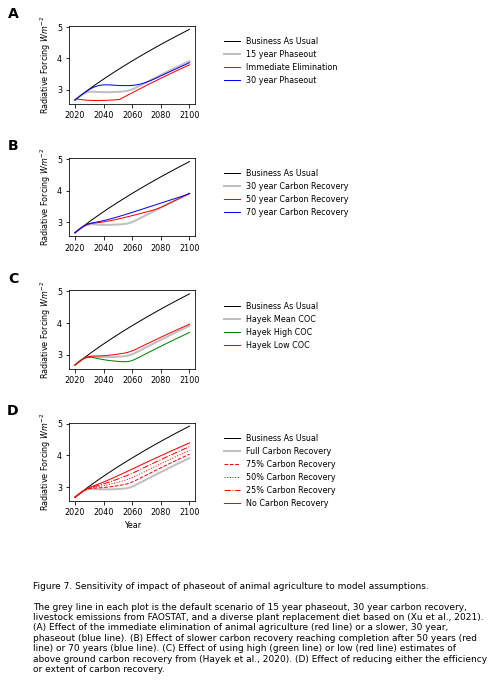

In [206]:
fignum = 7
pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    df = scenarios.loc[2020:2100]
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))
    
    panelw = 1.75
    panelh = panelw/1.61

    margin_top = 1
    margin_between = .75

    x = [1.5,7 - panelw]
    y = [figh - margin_top - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

    axes = []

    for i in [0,1,2,3]:
        axes.append(fig.add_axes([x[0]/figw,y[i]/figh,panelw/figw,panelh/figh]))
            
    ax = axes[0]
    l1 = ax.plot(df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    l2 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_PR_F'],color='grey',linewidth=2,alpha=.5)
    l3 = ax.plot(df['RFC|PH00_CR30_RP100_BAU_CR_F'],color='red',linewidth=1)
    l4 = ax.plot(df['RFC|PH30_CR30_RP100_BAU_SR_F'],color='blue',linewidth=1)
    
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    ax.legend([l1[0],l2[0],l3[0],l4[0]],['Business As Usual',
                                         '15 year Phaseout','Immediate Elimination','30 year Phaseout',
                                      ],bbox_to_anchor=(1.2,0.9), borderaxespad=0, frameon=False)
    ax.text(label_x_offset-.2,1.1,"A",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    
    ax = axes[1]
    l1 = ax.plot(df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    l2 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_PR_F'],color='grey',linewidth=2,alpha=.5)
    l3 = ax.plot(df['RFC|PH15_CR50_RP100_BAU_PR_F'],color='red',linewidth=1)
    l4 = ax.plot(df['RFC|PH15_CR70_RP100_BAU_PR_F'],color='blue',linewidth=1)
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    ax.legend([l1[0],l2[0],l3[0],l4[0]],['Business As Usual',
                                         '30 year Carbon Recovery','50 year Carbon Recovery','70 year Carbon Recovery'
                                      ],bbox_to_anchor=(1.2,0.9), borderaxespad=0, frameon=False)
    ax.text(label_x_offset-.2,1.1,"B",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    
    ax = axes[2]
    
    l1 = ax.plot(df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    l2 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_PR_F'],color='grey',linewidth=2,alpha=.5)
    l3 = ax.plot(df['RFC|Phaseout|Hayek High'],color='green',linewidth=1)
    l4 = ax.plot(df['RFC|Phaseout|Hayek Low'],color='red',linewidth=1)
    #l5 = ax.plot(df['RFC|Phaseout|Hayek No Soil'],color='red',label='Phaseout w/Crop Replacement',linewidth=1)
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    ax.legend([l1[0],l2[0],l3[0],l4[0]],['Business As Usual',
                                         'Hayek Mean COC','Hayek High COC', 'Hayek Low COC'
                                      ],bbox_to_anchor=(1.2,0.9), borderaxespad=0, frameon=False)
    ax.text(label_x_offset-.2,1.1,"C",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    
    ax = axes[3]
    l1 = ax.plot(df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    l2 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_PR_F'],color='grey',linewidth=2,alpha=.5)
    l3 = ax.plot(df['RFC|PH15_CR30_RP075_BAU_PR_F'],color='red',label='75% Recovery Percent ',linewidth=1,linestyle='dashed')  
    l4 = ax.plot(df['RFC|PH15_CR30_RP050_BAU_PR_F'],color='red',label='50% Recovery Percent ',linewidth=1,linestyle='dotted')  
    l5 = ax.plot(df['RFC|PH15_CR30_RP025_BAU_PR_F'],color='red',label='25% Recovery Percent ',linewidth=1,linestyle='dashdot')  
    l6 = ax.plot(df['RFC|PH15_CR30_RP000_BAU_PR_F'],color='red',label='no Carbon Recovery',linewidth=1)  
    
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)  
    ax.set_xlabel('Year',fontsize=8)
    ax.legend([l1[0],l2[0],l3[0],l4[0],l5[0],l6[0]],['Business As Usual',
                                         'Full Carbon Recovery',
                                         '75% Carbon Recovery', 
                                         '50% Carbon Recovery', 
                                         '25% Carbon Recovery', 
                                         'No Carbon Recovery'
                                      ],bbox_to_anchor=(1.2,0.9), borderaxespad=0, frameon=False)
    
    ax.text(label_x_offset-.2,1.1,"D",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    
    flh = r"Figure %d. Sensitivity of impact of phaseout of animal agriculture to model assumptions." % fignum
    
    flt = r'''The grey line in each plot is PHASE-POD, the default scenario of 15 year phaseout, 30 year carbon recovery, livestock emissions from
FAOSTAT, and a diverse plant replacement diet based on (Xu et al., 2021). (A) Effect of the immediate elimination of animal agriculture
(red line) or a slower, 30 year, phaseout (blue line). (B) Effect of slower carbon recovery reaching completion after 50 years (red line)
or 70 years (blue line). (C) Effect of using high (green line) or low (red line) estimates of above ground carbon recovery from (Hayek et al., 2020).
(D) Effect of reducing either the efficiency or extent of carbon recovery.'''
    
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=100)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")
    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

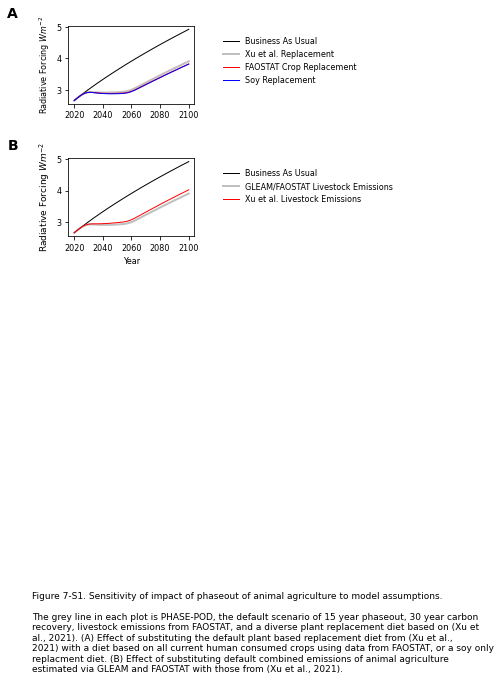

In [207]:
fignum = 7
supnum = 1
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    df = scenarios.loc[2020:2100]
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))
    
    panelw = 1.75
    panelh = panelw/1.61

    margin_top = 1
    margin_between = .75

    x = [1.5,7 - panelw]
    y = [figh - margin_top - (i+1) * panelh - i * (margin_between) for i in [0,1]]

    axes = []

    for i in [0,1]:
        axes.append(fig.add_axes([x[0]/figw,y[i]/figh,panelw/figw,panelh/figh]))
            
    ax = axes[0]
    l1 = ax.plot(df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    l2 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_PR_F'],color='grey',linewidth=2,alpha=.5)
    l3 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_CR_F'],color='red',linewidth=1)
    l4 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_SR_F'],color='blue',linewidth=1)
    
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    ax.legend([l1[0],l2[0],l3[0],l4[0]],['Business As Usual',
                                         'Xu et al. Replacement','FAOSTAT Crop Replacement','Soy Replacement',
                                      ],bbox_to_anchor=(1.2,0.9), borderaxespad=0, frameon=False)
    ax.text(label_x_offset-.2,1.1,"A",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    
    ax = axes[1]
    l1 = ax.plot(df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    l2 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_PR_F'],color='grey',linewidth=2,alpha=.5)
    l3 = ax.plot(df['RFC|PH15_CR30_RP100_BAU_PR_X'],color='red',linewidth=1)
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=9)       
    ax.set_xlabel('Year',fontsize=8)
    ax.legend([l1[0],l2[0],l3[0]],['Business As Usual',
                                         'GLEAM/FAOSTAT Livestock Emissions','Xu et al. Livestock Emissions',
                                      ],bbox_to_anchor=(1.2,0.9), borderaxespad=0, frameon=False)
    ax.text(label_x_offset-.2,1.1,"B",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    
    flh = r"Figure %d-S%d. Sensitivity of impact of phaseout of animal agriculture to model assumptions." % (fignum,supnum)
    
    flt = r'''The grey line in each plot is PHASE-POD, the default scenario of 15 year phaseout, 30 year carbon recovery, livestock emissions from
FAOSTAT, and a diverse plant replacement diet based on (Xu et al., 2021). (A) Effect of substituting the default plant based replacement
diet from (Xu et al., 2021) with a diet based on all current human consumed crops using data from FAOSTAT, or a soy only replacment diet.
(B) Effect of substituting default combined emissions of animal agriculture estimated via GLEAM and FAOSTAT with those from (Xu et al., 2021).'''
    
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=100)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")
    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

### Figure 8 - SSP livestock consumption

In [190]:
dfp['SSP'] = dfp.Scenario.apply(lambda x: x.split('-')[0])
dfp['SSP-TARGET'] = dfp.Scenario.apply(lambda x: x.split('-')[1])

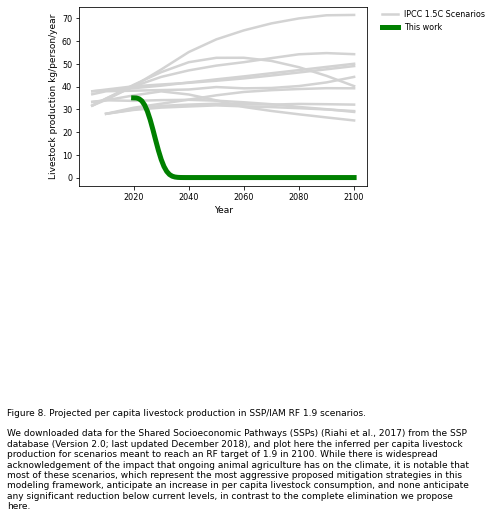

In [191]:
fignum = 8
pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 4
    panelh = panelw/1.61
    
    margin_top = 3
    
    panelx = 2.0
    panely = figh - margin_top - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    dfpw19 = dfp[(dfp.Region == "World") & (dfp['SSP-TARGET'] == '19')].copy()
    dfpw19.Year = dfpw19.Year.astype('int64')
    for i,r in dfpw19.groupby(['Model','Scenario']):
        ax.plot(r.Year,1e+3 * r['Agricultural Production|Livestock']/r['Population'],c='lightgrey',linewidth=2.5)
    
    r = scenarios.loc[2020:2100]
    ax.plot(r.aa_exponential_phaseout_15y * 35, c='green', linewidth = 5)
    
    ax.set_xticks([2020,2040,2060,2080,2100])
    ax.set_xlabel("Year")
    ax.set_ylabel("Livestock production kg/person/year")
    
    legend_lines = [
        Line2D([0],[0],color='lightgrey', lw=2.5),
        Line2D([0],[0],color='green', lw=5),
    ]

    legend_labels = [
        'IPCC 1.5C Scenarios',
        'This work',
    ]

    plt.legend(legend_lines,legend_labels,bbox_to_anchor=(1.04,1.0), borderaxespad=0, frameon=False)

    
    flh = "Figure %d. Projected per capita livestock production in SSP/IAM RF 1.9 scenarios." % fignum
    
    flt = '''We downloaded data for the Shared Socioeconomic Pathways (SSPs) (Riahi et al., 2017)
from the SSP database (Version 2.0; last updated December 2018), and plot here the
inferred per capita livestock production for scenarios meant to reach an RF target
of 1.9 in 2100. While there is widespread acknowledgement of the impact that ongoing
animal agriculture has on the climate, it is notable that most of these scenarios,
which represent the most aggressive proposed mitigation strategies in this modeling
framework, anticipate an increase in per capita livestock consumption,
and none anticipate any significant reduction below current levels,
in contrast to the complete elimination we propose here.'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")
        
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)

